In [1]:
# # Install required packages (NB: they may already be installed on your machine)
# install.packages("tidyverse")
# install.packages("infer")
# install.packages("janitor")
# install.packages("repr")
# install.packages("stringr")
# install.packages("waffle", repos = "https://cinc.rud.is")
# install.packages("plyr")
# install.packages("ggthemes")
# install.packages("knitr")
# install.packages("kableExtra")
# install.packages("RColorBrewer")

# # Waffle is sometimes finicky, so you might also need this to run this notebook locally
# remotes::install_github("hrbrmstr/waffle")



In [2]:
# Load required packages
library(plyr)
library(tidyverse)
library(infer)
library(janitor)
library(repr)
library(stringr)
library(waffle)
library(ggthemes)
library(knitr)
# library(kableExtra)
library(RColorBrewer)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::arrange()   masks plyr::arrange()
x purrr::compact()   masks plyr::compact()
x dplyr::count()     masks plyr::count()
x dplyr::failwith()  masks plyr::failwith()
x dplyr::filter()    masks stats::filter()
x dplyr::id()        masks plyr::id()
x dplyr::lag()       masks stats::lag()
x dplyr::mutate()    masks plyr::mutate()
x dplyr::rename()    masks plyr::rename()
x dplyr::summarise() masks plyr::summarise()
x dplyr::summarize() masks plyr::summarize()


Attaching package: 'janitor'


The following objects are masked from 'package:stats':

    chisq.test, fisher.test




In [3]:
# Custom ggplot theme for use throughout the analysis
# Idea from [Joey Stanley](https://joeystanley.com/blog/custom-themes-in-ggplot2)
theme_stat201 <- function (width = 12, height = 5) { 
    options(repr.plot.width = width, repr.plot.height = height)
    theme_bw(base_size = 14) %+replace% 
        theme(
            plot.title = element_text(hjust = 0.5) 
        )
}

In [4]:
# A helper function to generate figure numbers
create_caption <- function (figure_number, title) {
    print(paste(sprintf("Figure #%d:", figure_number), title))
}
create_caption(0, "Hello, world!")

[1] "Figure #0: Hello, world!"


In [5]:
# The seed used for the entirety of our analysis
SEED <- 12345

# Examining the Impact of COVID-19 on the Proportion of Theft-Related Crimes in Vancouver

**Authors** Group 4, Project Proposal (Acky Xu, Adam Mitha, Icy Xu, Michael DeMarco)

**Abstract** This project looks at the impact of the COVID-19 pandemic on theft-related crime in select Vancouver neighborhoods. Inferential techniques are applied to estimate the difference in the proportion of theft crime relative to all crime between 2020 and the mean proportion of the three previous years, 2017 to 2019; we test to see if there has been a statistically significant change in the proportion of theft related crime across individual Vancouver neighborhoods. We anticipated we would find a significant difference in theft related crime overall due to, presumably, the economic hardship induced by the COVID-19 pandemic in 2020; in the end, we instead found that roughly half of all examined neighborhoods saw no statistically significant change in theft related crime; there were neighborhoods that did see a statistically significant change in the proportion of theft-related crime, but this change did not seem to correlate with each neighborhoods' average income, as anticipated.

<p style="display: block; text-align: center;">
    <img style="display: block; margin: 0 auto;" src="./vpd.jpg" alt="A VPD car" width="50%" />
</p>

<p style="text-align: center;"><i>A Vancouver Police Department (VPD) car.</i></p>

## Introduction

### Background 

Since the beginning of the COVID-19 pandemic in March of 2020, many have discussed the issue of alleged increasing crime rates both globally and within Metro Vancouver. Indeed, an unprecedented economic contraction [[Statistics Canada, 1]](https://www150.statcan.gc.ca/n1/pub/11-631-x/2020004/conclusions-eng.htm) coupled with fewer resources, such as shelters or food banks, has driven an increase in many types of crime, including in fraud and counterfeiting crime [[Interpol, 2]](https://www.interpol.int/en/News-and-Events/News/2019/Operation-Pangea-shining-a-light-on-pharmaceutical-crime), hate crimes [[ABC News, 3]](https://abcnews.go.com/US/fbi-warns-potential-surge-hate-crimes-asian-americans/story?id=69831920)—with those of East Asian descent being impacted most significantly—and domestic violence [[UN News, 4]](https://news.un.org/en/story/2020/04/1061052).

These spikes have led to tension between municipal governments and police departments with respect to budgeting in the wake of the economic depravity of the COVID-19 era. The City of Vancouver, specifically, enacted a freeze on the police budget in 2021 [[CBC, 5]](https://www.cbc.ca/news/canada/british-columbia/city-of-vancouver-freezes-police-department-funding-as-part-of-2021-budget-1.5833731). However, there is little publicly available Vancouver-focused analysis on both theft-related crime specifically and trends in crime generally in the years leading up to that decision.

Existing literature relating to crime and the COVID-19 pandemic has primarily focused on many types of "global" crime (e.g., organized crime, terrorist attacks), and has largely concluded that on the whole, these types of crimes are increasing through the pandemic year; in our analysis, we'll look closely at "petty" crimes, specifically theft, and see how, if at all, the rate of theft crime has changed amidst the pandemic. We analyze all Metro Vancouver neighborhoods we have data for—twenty-four neighborhoods in total—for our analysis. In the appendix, we visualize the socioeconomic spectrum within Vancouver, grouped by neighborhood, which will be discussed as a part of our analysis. To do so, we used the City of Vancouver's 2016 census data on "local area profiles," and explore the "average total incomes among residents" [[City of Vancouver, 9]](https://opendata.vancouver.ca/explore/dataset/census-local-area-profiles-2016/information/). Here's a snapshot of what the data looks like:

| Neighborhood | Average Income (2016, CAD) |
|-:|-:|
| Arbutus Ridge | \$62,675 |
| Downtown | \$63,251 |
| Dunbar/Southlands | \$78,117 |
| Fairview | \$61,627 |
| Grandview/Woodland | \$42,896 |
| Hastings/Sunrise | \$38,258 |

<p style="text-align:center;">Figure 1: A sample of wealth in Vancouver neighborhoods.<p>

(While the VPD has no direct data for neighborhood wealth, we can use the City of Vancouver's local profiles as they match the VPD's neighborhood classifications. Other studies of mean incomes among residents in Vancouver neighborhoods aren't guaranteed to share the same neighborhood boundaries as the City of Vancouver and VPD data sets.) It should be noted that income levels in Vancouver neighborhoods do not naturally split into a simple dichotomy of "upper class," "middle class," or "lower class"; there are also notable outliers such as Shaughnessy, with an average 2016 income of \$118,668. For more information, the reader is encouraged to look at the [appendix](#appendix) at the end of this report.

### Question

We are interested in exploring how much, if at all, the proportion of petty crime rates have changed in Metro Vancouver over the last year. We will compare crime rates from 2017 to 2020 in twenty-four neighborhoods characteristic of various strata of the full economic spectrum. Our analysis is narrowed to focusing on specifically theft, so we can best understand the intertwined relationships between the economic hardships brought forward over this last year and trends in crime that would seemingly be induced by someone incurring job loss, for example.

Therefore, our research question is as follows: _"How has the proportion of theft-related crime changed, if at all, in Vancouver during 2020, the year of the COVID-19 pandemic, when compared to the average of the previous three years (2017 to 2019) across the various strata of Vancouver's economic spectrum, studied via twenty four Vancouver neighborhoods?"_

### Data set

We're considering our sample to be what is available in the Vancouver Police Department's database. Within the data set description, the VPD mentions "[t]he information provided [...] does not reflect the total number of calls or complaints made to the VPD" and "the crime classification [...] may change at any time based on the dynamic nature of police investigations." This alone means we cannot consider the data set to be entirely representative of all crime in Vancouver. Additionally, we have to consider that many crimes go unreported for various reasons, such as for a fear of not being believed, insecurity, and a fear of getting into trouble; therefore, we have further reason to  presume this data is not completely representative of both all crimes and all thefts within Vancouver. While there is no specific study for unreported crimes statistics in Vancouver, Statistic's Canada's "Police-reported crime statistics in Canada, 2019" survey indicated that just "one-third (31\%) of crimes" are reported to the police [[Statistics Canada, 13]](https://www150.statcan.gc.ca/n1/pub/85-002-x/2020001/article/00010-eng.htm).
 
Our population is _all_ actual crime that occurred in Vancouver, not just reported crime. Of course it is impossible to know how much crime actually occurred, but through our data set sample we'll be able to produce an estimate. Unfortunately, as we are working with the proportion of theft-related crime to _overall_ crime, attitudes towards policing over time becomes a rather significant confounding variable, as that could dramatically impact an individual's willingness to report a crime. There is significant cause to consider this confounding as well, as 2020 saw both the killing of George Floyd by a Minneapolis police officer and little action taken by the government to reconcile for the missing and murdered Indigenous women (MMIW) crisis here in Canada, leading to furthered distrust between citizens and Canada's metropolitan police forces; this among other limitations will be discussed further in our analysis section. 

We will be using the Vancouver Police Department's Open Crime Data [[VPD, 6]](https://geodash.vpd.ca/opendata/) to answer our research question. In particular, we'll need three columns from the data set:

| Column | Description | Notes |
|-|-|-|
| Year | "A four-digit field that indicates the year when the reported crime activity" | We'll use data, specifically, from January 1st, 2017 to December 31st, 2020. |
| Type | "The type of crime activities" | We're considering theft crime to be all crime types with "theft" explicitly in the name. |
| Neighborhood | "Neighborhoods within the City of Vancouver are based on the census tract (CT) concept within census metropolitan area (CMA)." | We'll take three neighborhoods, representing the full economic spectrum. |

<p style="text-align:center;">Figure 2: A description of the VPD Open Crime data set.</p>

Our random variable of interest is the difference in the proportion of theft-related crime with respect to all crime between the mean of 2017 to 2019 and 2020 (i.e., before and during the COVID-19 pandemic). Given our population is all Vancouver crime, our parameter of interest is the difference in the proportion of theft related crime from the last three years, 2017 to 2019, to 2020.

We will be estimating trends for all reported _and_ unreported crime in Vancouver by making estimates with our data set of reported crime across twenty four different Vancouver neighborhoods, each with its own level of wealth.

## Preliminary Results

We'll start by importing the dataset from it's original source [[VPD, 6]](https://geodash.vpd.ca/opendata), loading it into a dataframe and inspecting the results.

In [6]:
# Download the file to wherever your Jupyter notebook is located
url <- "https://geodash.vpd.ca/opendata/crimedata_download/crimedata_csv_all_years.zip"
filename <- "crime_data.zip"
download.file(url, destfile = filename)

# Data comes in as a zip, so we'll need to extract it
unzip("crime_data.zip")

# Read in the desired file
crime_data <- read_csv("crimedata_csv_all_years.csv")


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  TYPE = col_character(),
  YEAR = col_double(),
  MONTH = col_double(),
  DAY = col_double(),
  HOUR = col_double(),
  MINUTE = col_double(),
  HUNDRED_BLOCK = col_character(),
  NEIGHBOURHOOD = col_character(),
  X = col_double(),
  Y = col_double()
)




In [7]:
# Inspect the first and last three rows of the data frame
head(crime_data, n = 3)
tail(crime_data, n = 3)
create_caption(3, "Exploring the initial VPD crime data set.")

TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Break and Enter Commercial,2012,12,14,8,52,NA,Oakridge,491285.0,5453433
Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174


TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Vehicle Collision or Pedestrian Struck (with Injury),2016,6,20,18,11,YUKON ST / W KING EDWARD AVE,Riley Park,491786,5455143
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,3,9,49,YUKON ST / W KING EDWARD AVE,Riley Park,491835,5455126
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,27,14,40,YUKON ST / W KING EDWARD AVE,Riley Park,491835,5455126


[1] "Figure #3: Exploring the initial VPD crime data set."


Our data largely comes in a "tidy" format already. By tidy, we're verifying (from the DSCI 100 course textbook [[Data Science: A First Introduction, 12]](https://ubc-dsci.github.io/introduction-to-datascience/), verbatim, which in turn is from Wickham and others [[R for Data Science, 11]](https://r4ds.had.co.nz/)): 
> * each row is a single observation,
> * each column is a single variable, and
> * each value is a single cell

However, there are four steps we could take to improve the data set for our use: 
1. clean up the column names,
2. remove N/As,
3. select only data relevant to our analysis, and
4. convert crime types and neighborhoods to a factor, since we're working with proportions (i.e., categorical data).

We're primarily interested in the year, type and neighborhood of crimes, so we'll extract those columns and discard the rest. In addition, we would like to focus on the years 2017 to 2020.

In [8]:
# 1. Generally, in R, you don't see ALL CAPS column names,
# so we can modify the column names manually (with the help)
# of the janitor library

oldw <- getOption("warn")
options(warn = -1) # Suppress "unable to translate '<U+00C4>' to native encoding" error messages

crime_data <- crime_data %>% clean_names()
head(crime_data)
create_caption(4, "Tidying the column names in the crime data.")

options(warn = oldw)

type,year,month,day,hour,minute,hundred_block,neighbourhood,x,y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Break and Enter Commercial,2012,12,14,8,52,NA,Oakridge,491285.0,5453433
Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174
Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9,5459166
Break and Enter Commercial,2020,7,28,19,12,10XX ALBERNI ST,West End,491015.9,5459166
Break and Enter Commercial,2005,11,14,3,9,10XX ALBERNI ST,West End,491021.4,5459161


[1] "Figure #4: Tidying the column names in the crime data."


In [9]:
# 2. Remove all NAs (Note: na.omit(...) applies to the entire data frame, 
# but neighbourhood is used as an example)

total_rows <- crime_data %>% nrow()
print(sprintf("There are %d rows in the data frame", total_rows))

na_neighbourhoods <- sum(is.na(crime_data$neighbourhood))
print(sprintf("Originally, there were %d NA values in the neighbourhood column", na_neighbourhoods))

crime_data <- na.omit(crime_data)

na_neighbourhoods <- sum(is.na(crime_data$neighbourhood))
print(sprintf("Now, there are %d NA values in the neighbourhood column", na_neighbourhoods))

[1] "There are 668167 rows in the data frame"
[1] "Originally, there were 70135 NA values in the neighbourhood column"
[1] "Now, there are 0 NA values in the neighbourhood column"


In [10]:
# 3. Select only type, year, neighbourhood
# Filter to the date range of 2017-2020
crime_data <- crime_data %>% 
    select(type, year, neighbourhood) %>%
    filter(2017 <= year & year <= 2020)

head(crime_data)
create_caption(5, "Selecting and filtering our crime data.")

type,year,neighbourhood
<chr>,<dbl>,<chr>
Break and Enter Commercial,2019,Fairview
Break and Enter Commercial,2019,West End
Break and Enter Commercial,2020,West End
Break and Enter Commercial,2017,West End
Break and Enter Commercial,2018,West End
Break and Enter Commercial,2020,West End


[1] "Figure #5: Selecting and filtering our crime data."


In [11]:
# 4. Now, we'll convert `neighbourhood` and `type` to a factor, 
# since we're considering it categorical data
crime_data <- crime_data %>%
    mutate(type = as_factor(type)) %>%
    mutate(neighbourhood = as_factor(neighbourhood))

head(crime_data)
create_caption(6, "Converting crime data's column data types.")

type,year,neighbourhood
<fct>,<dbl>,<fct>
Break and Enter Commercial,2019,Fairview
Break and Enter Commercial,2019,West End
Break and Enter Commercial,2020,West End
Break and Enter Commercial,2017,West End
Break and Enter Commercial,2018,West End
Break and Enter Commercial,2020,West End


[1] "Figure #6: Converting crime data's column data types."


Next, let's see how many different types of crimes there are present in our data set.

In [12]:
# Grab all unique crime types, and print them in a pretty way
crime_types <- unique(crime_data$type)
print(crime_types)

[1] Break and Enter Commercial                            
[2] Break and Enter Residential/Other                     
[3] Mischief                                              
[4] Other Theft                                           
[5] Theft from Vehicle                                    
[6] Theft of Bicycle                                      
[7] Theft of Vehicle                                      
[8] Vehicle Collision or Pedestrian Struck (with Fatality)
[9] Vehicle Collision or Pedestrian Struck (with Injury)  
9 Levels: Break and Enter Commercial ... Vehicle Collision or Pedestrian Struck (with Injury)


As was mentioned in the introduction, we're interested in theft related crime. Let's create a list of all theft related crime we see in this data set.

In [13]:
theft_crimes <- c("Other Theft", "Theft from Vehicle", 
                  "Theft of Bicycle", "Theft of Vehicle")

We can also check the neighborhoods present in this data set.

In [14]:
# Grab all unique crime types, and print them in a pretty way
neighbourhoods <- unique(crime_data$neighbourhood)
print(neighbourhoods)
print(sprintf("There are %d unique neighbourhoods available in this data set.", length(neighbourhoods)))

 [1] Fairview                  West End                 
 [3] Central Business District Hastings-Sunrise         
 [5] Strathcona                Grandview-Woodland       
 [7] Mount Pleasant            Sunset                   
 [9] Kensington-Cedar Cottage  Stanley Park             
[11] Shaughnessy               Marpole                  
[13] Oakridge                  Kitsilano                
[15] Victoria-Fraserview       Kerrisdale               
[17] West Point Grey           Riley Park               
[19] Arbutus Ridge             Renfrew-Collingwood      
[21] Killarney                 South Cambie             
[23] Dunbar-Southlands         Musqueam                 
24 Levels: Fairview West End Central Business District ... Musqueam
[1] "There are 24 unique neighbourhoods available in this data set."


We're hoping to compare crime rates across years in neighborhoods that represent a distribution of average income levels. For our proposal, we're going to be using all neighborhoods available in the VPD's data set; a distribution of the levels of wealth these neighborhoods demonstrate is available in the appendix and further discussion on why the relationship between economy and crime is discussion in our analysis.

In [15]:
# Explore data set as it currently stands after some tidying
head(crime_data, n = 3)
tail(crime_data, n = 3)
create_caption(7, "Exploring our tidied crime data once again.")

type,year,neighbourhood
<fct>,<dbl>,<fct>
Break and Enter Commercial,2019,Fairview
Break and Enter Commercial,2019,West End
Break and Enter Commercial,2020,West End


type,year,neighbourhood
<fct>,<dbl>,<fct>
Vehicle Collision or Pedestrian Struck (with Injury),2019,Mount Pleasant
Vehicle Collision or Pedestrian Struck (with Injury),2018,Mount Pleasant
Vehicle Collision or Pedestrian Struck (with Injury),2020,Mount Pleasant


[1] "Figure #7: Exploring our tidied crime data once again."


Now, to get a better sense of our data set, we'll produce three plots to explore, at a high level, what crime looks like in Vancouver both over time and by neighborhood. Our three plots will be:

1. A line plot of total police-reported crime over time, grouped by neighborhood; this will demonstrate the change in total crime over time
2. A stacked bar chart showing a breakdown of crime type, grouped by neighborhood; this will demonstrate the relative frequencies of each crime type, by neighborhood
3. A waffle plot to show to crime types proportions, grouped by year; this will demonstrate the relative frequencies of each crime type, by year

Let's begin with the line plot.

In [16]:
# To produce our line plot, first, we'll need to compute the total amount of crime
# by neighborhood and year
neighbourhood_year_counts <- crime_data %>%
    group_by(neighbourhood, year) %>% 
    summarise(n = n())

head(neighbourhood_year_counts)
create_caption(8, "A tablet of counts of crime by neighborhood and year.")

`summarise()` has grouped output by 'neighbourhood'. You can override using the `.groups` argument.



neighbourhood,year,n
<fct>,<dbl>,<int>
Fairview,2017,1768
Fairview,2018,1795
Fairview,2019,2144
Fairview,2020,1787
West End,2017,2825
West End,2018,3029


[1] "Figure #8: A tablet of counts of crime by neighborhood and year."


[1] "Figure #9: A line plot depicting the number of total police-reported crimes over time by neighbourhood."


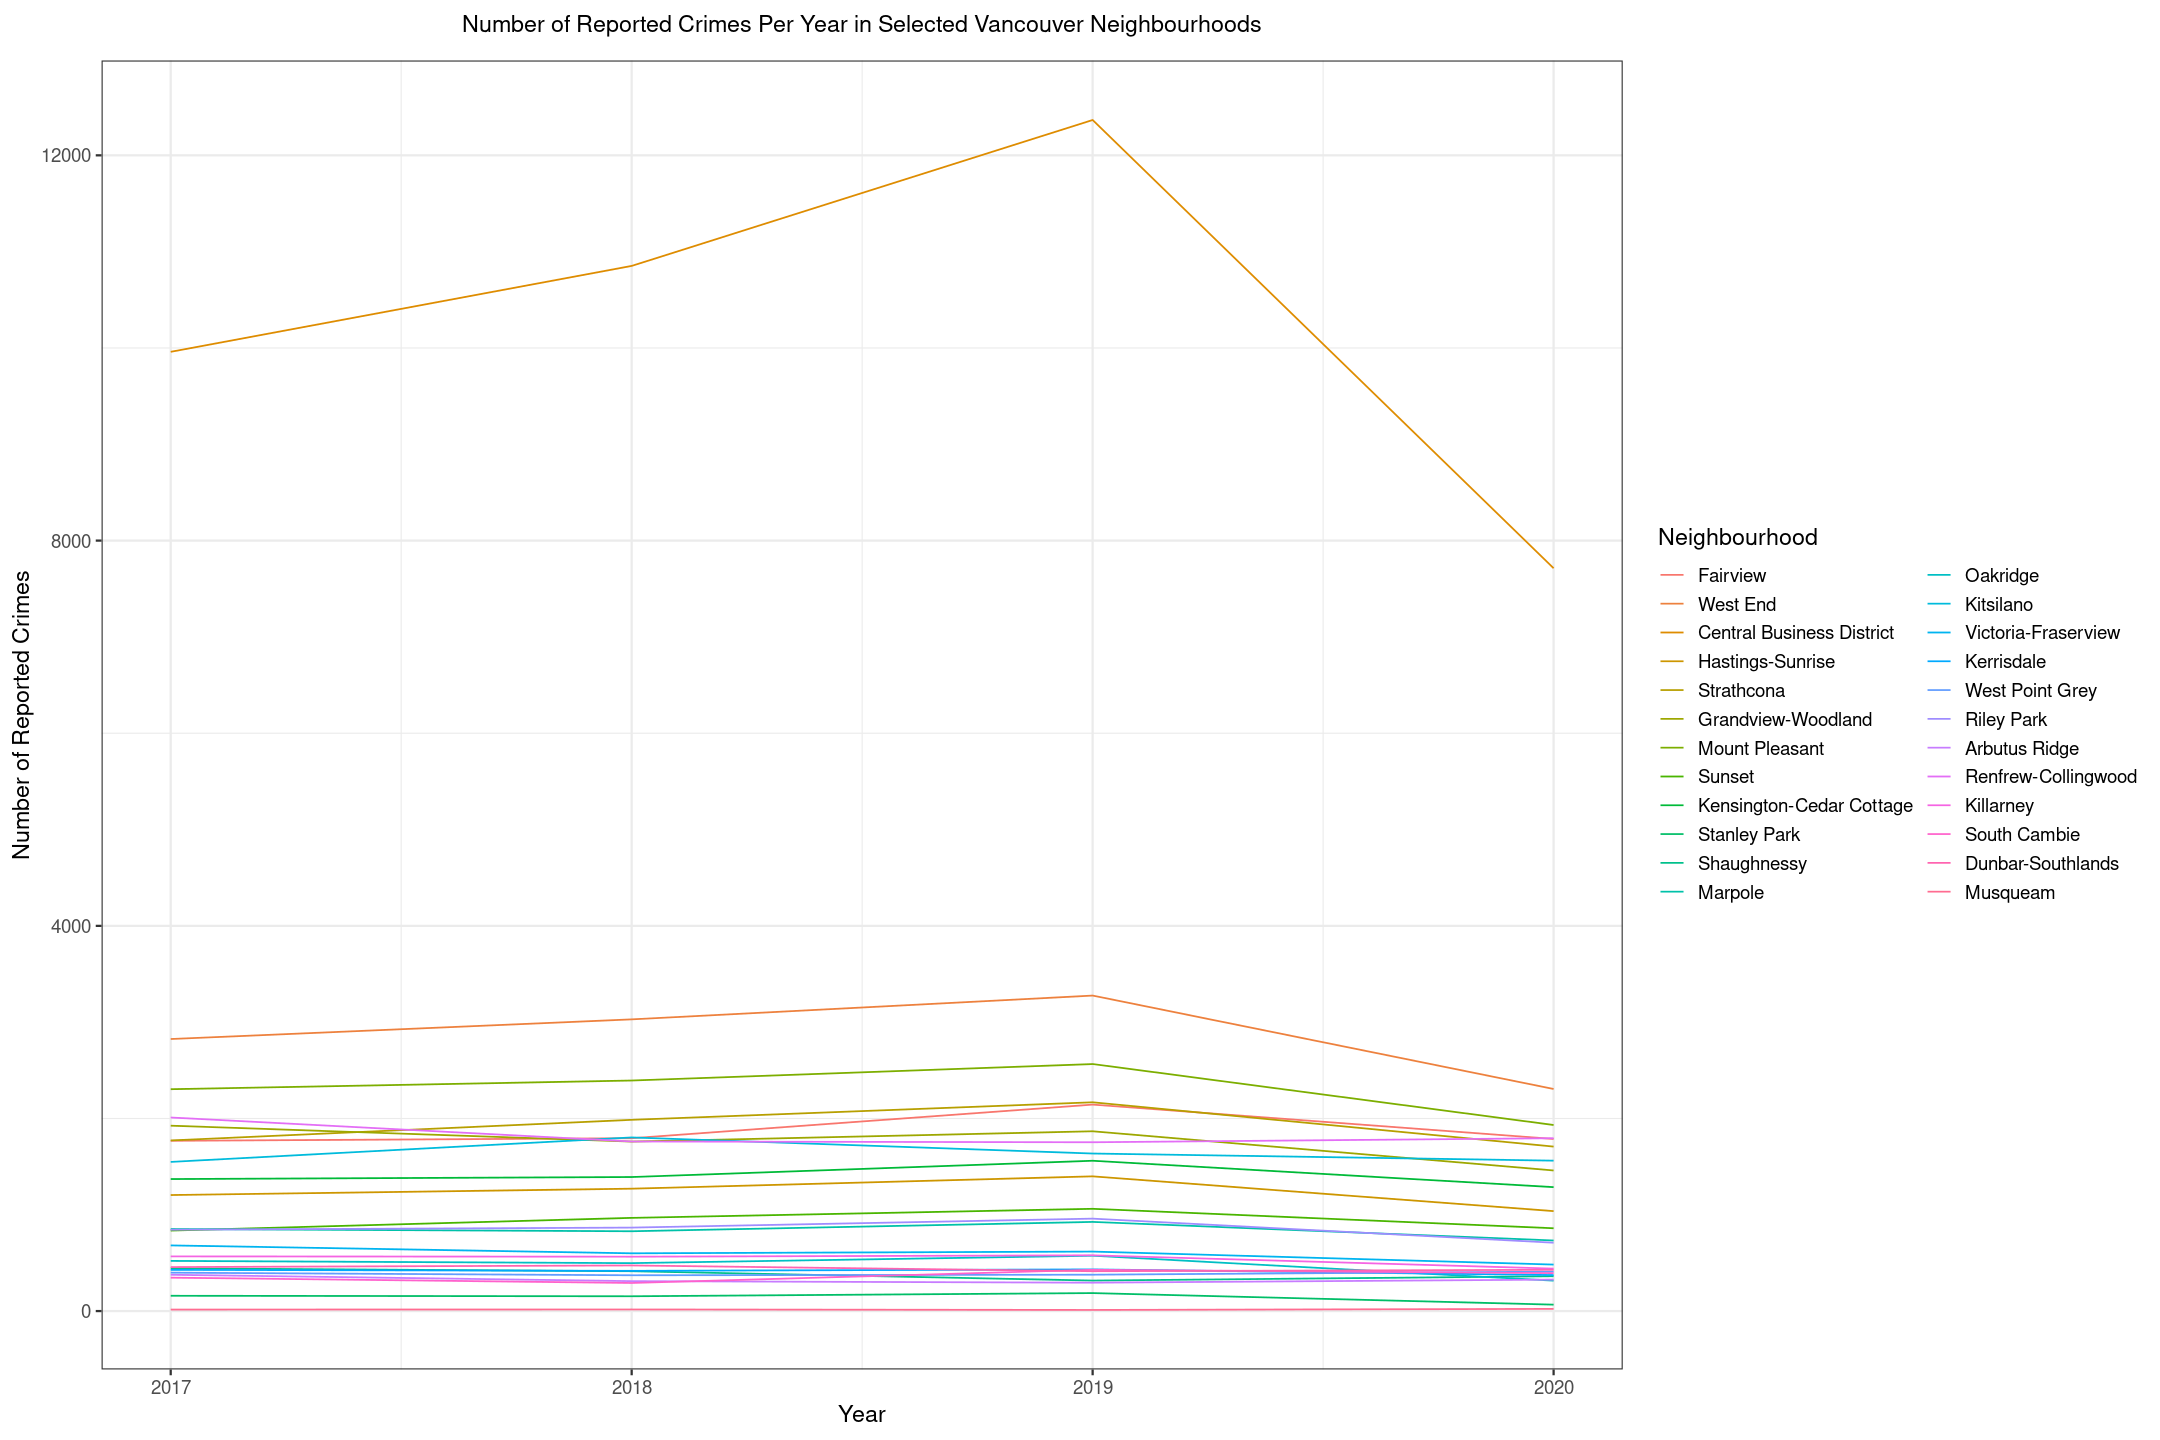

In [17]:
# 1. Finally, let's plot our data
crime_data_plot <- neighbourhood_year_counts %>%
    ggplot() +
    geom_line(aes(x = year, y = n, color = neighbourhood)) +
    scale_x_continuous(limits = c(2017, 2020)) +
    labs(x = "Year", y = "Number of Reported Crimes", color = "Neighbourhood") +
    ggtitle("Number of Reported Crimes Per Year in Selected Vancouver Neighbourhoods\n") +
    theme_stat201(18, 12)
crime_data_plot
create_caption(9, "A line plot depicting the number of total police-reported crimes over time by neighbourhood.")

It's clear that the crime is highest in Strathcona, followed by Marpole, and then Shaughnessy. Crime has also generally decreased in 2020, especially in Strathcona. 

Alongside checking the number of crimes total in each neighborhood, it's also worth looking at how much of each type of crime is represented in our data set. Let's now look at the stacked bar chart.

[1] "Figure #10: A stacked bar chart depicting the total number of crimes by type and neighbourhood."


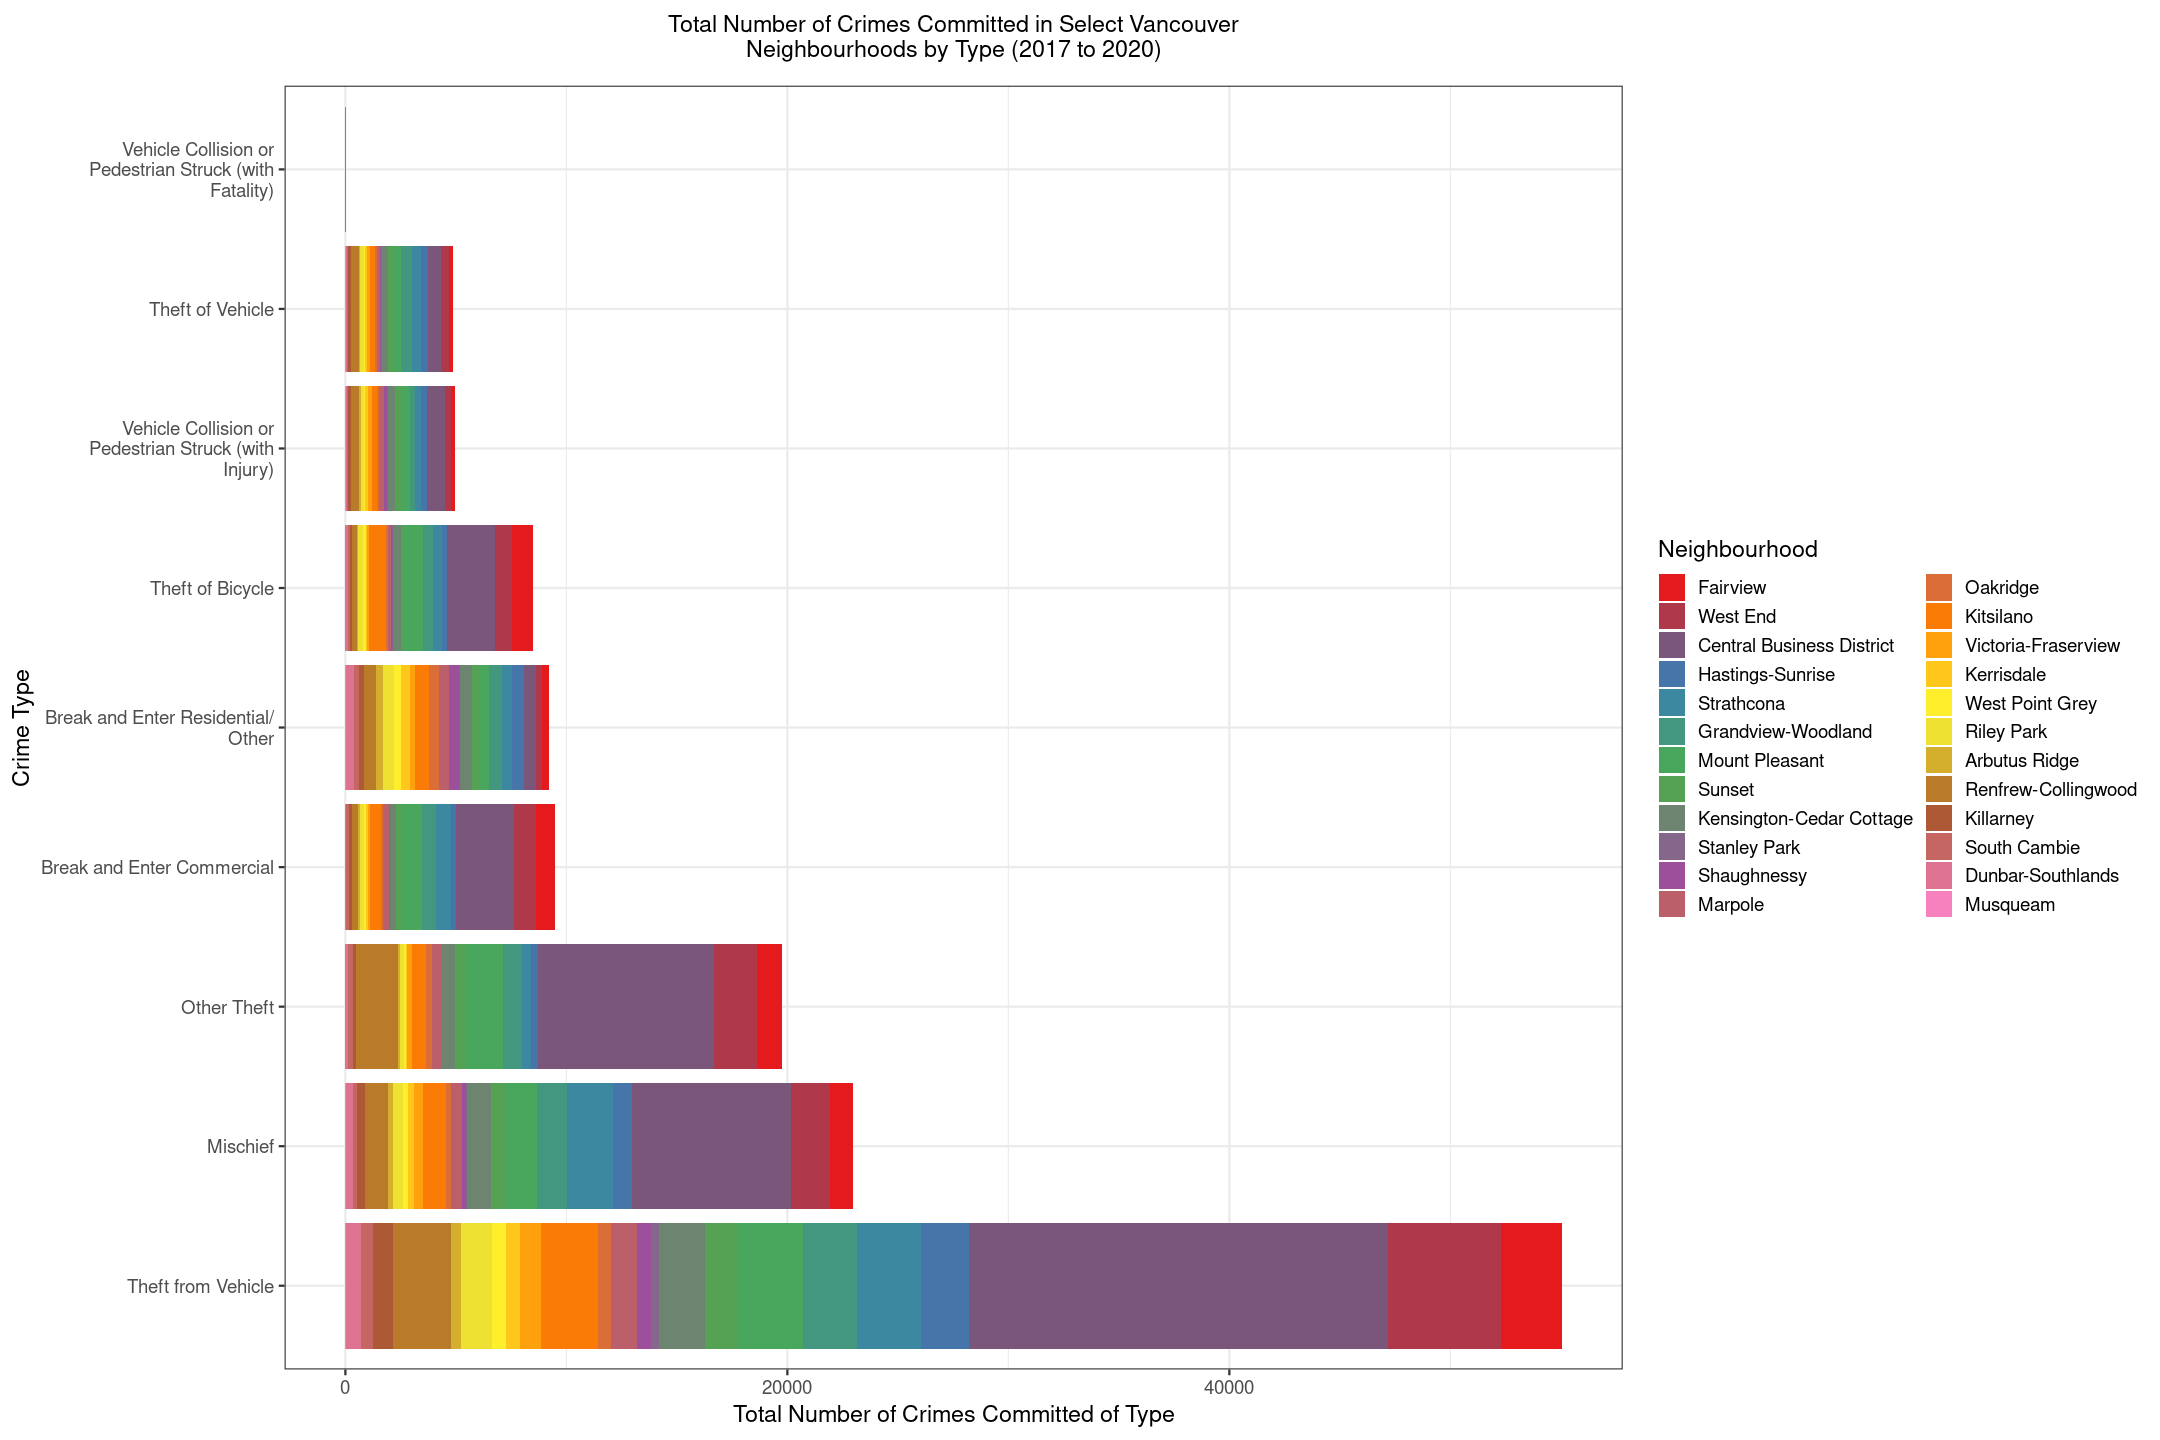

In [18]:
# 2. Note that the stringr::str_wrap call wraps the long label names for crime types, and
# reorder places the largest crime count on the bottom

# We need especially distinct colors here, since we have many neighbourhoods; by default, R makes a gradient that "blends" the neighborhoods together
neighbourhoods <- 24
colors <- colorRampPalette(brewer.pal(8, "Set1"))(neighbourhoods)

crime_type_bar_plot <- crime_data %>%
    ggplot(aes(x = reorder(str_wrap(type, 30), type, function(x) - length(x)), fill = neighbourhood)) +
    geom_bar(position = "stack") +
    labs(x = "Crime Type", y = "Total Number of Crimes Committed of Type", fill = "Neighbourhood") +
    ggtitle("Total Number of Crimes Committed in Select Vancouver\nNeighbourhoods by Type (2017 to 2020)\n") +
    coord_flip() +
    theme_stat201(18, 12) + 
    scale_fill_manual(values = colors)

# Vehicle collisions that result in fatality are (thankfully) very low,
# and almost distinguishable on the plot below                           
crime_type_bar_plot
create_caption(10, "A stacked bar chart depicting the total number of crimes by type and neighbourhood.")

This plot shows that theft from vehicle, in the Strathcona region, makes up a large proportion of all crimes committed. We can also see, thankfully, that vehicle collisions resulting in fatality make up such a small fraction of our data they're hard to distinguish.

Finally, we can look at a visualization of the relative frequencies of crime over the years through a waffle chart. N.B: Each individual square represents 30 police-reported crimes.

In [19]:
# Let's produce a count of the crime by year and type
crime_waffle <- crime_data %>%
    count(year, type) %>%
    mutate(n = n / 30)
head(crime_waffle)
create_caption(11, "A table showing proportions of types of crimes.")
# The geom_waffle() function will do some magic for us in terms of rounding

year,type,n
<dbl>,<fct>,<dbl>
2017,Break and Enter Commercial,73.20000
2017,Break and Enter Residential/Other,81.93333
2017,Mischief,178.80000
2017,Other Theft,182.40000
2017,Theft from Vehicle,430.13333
2017,Theft of Bicycle,73.23333


[1] "Figure #11: A table showing proportions of types of crimes."


[1] "Figure #12: A waffle plot depicting the proportion of each crime time by year."


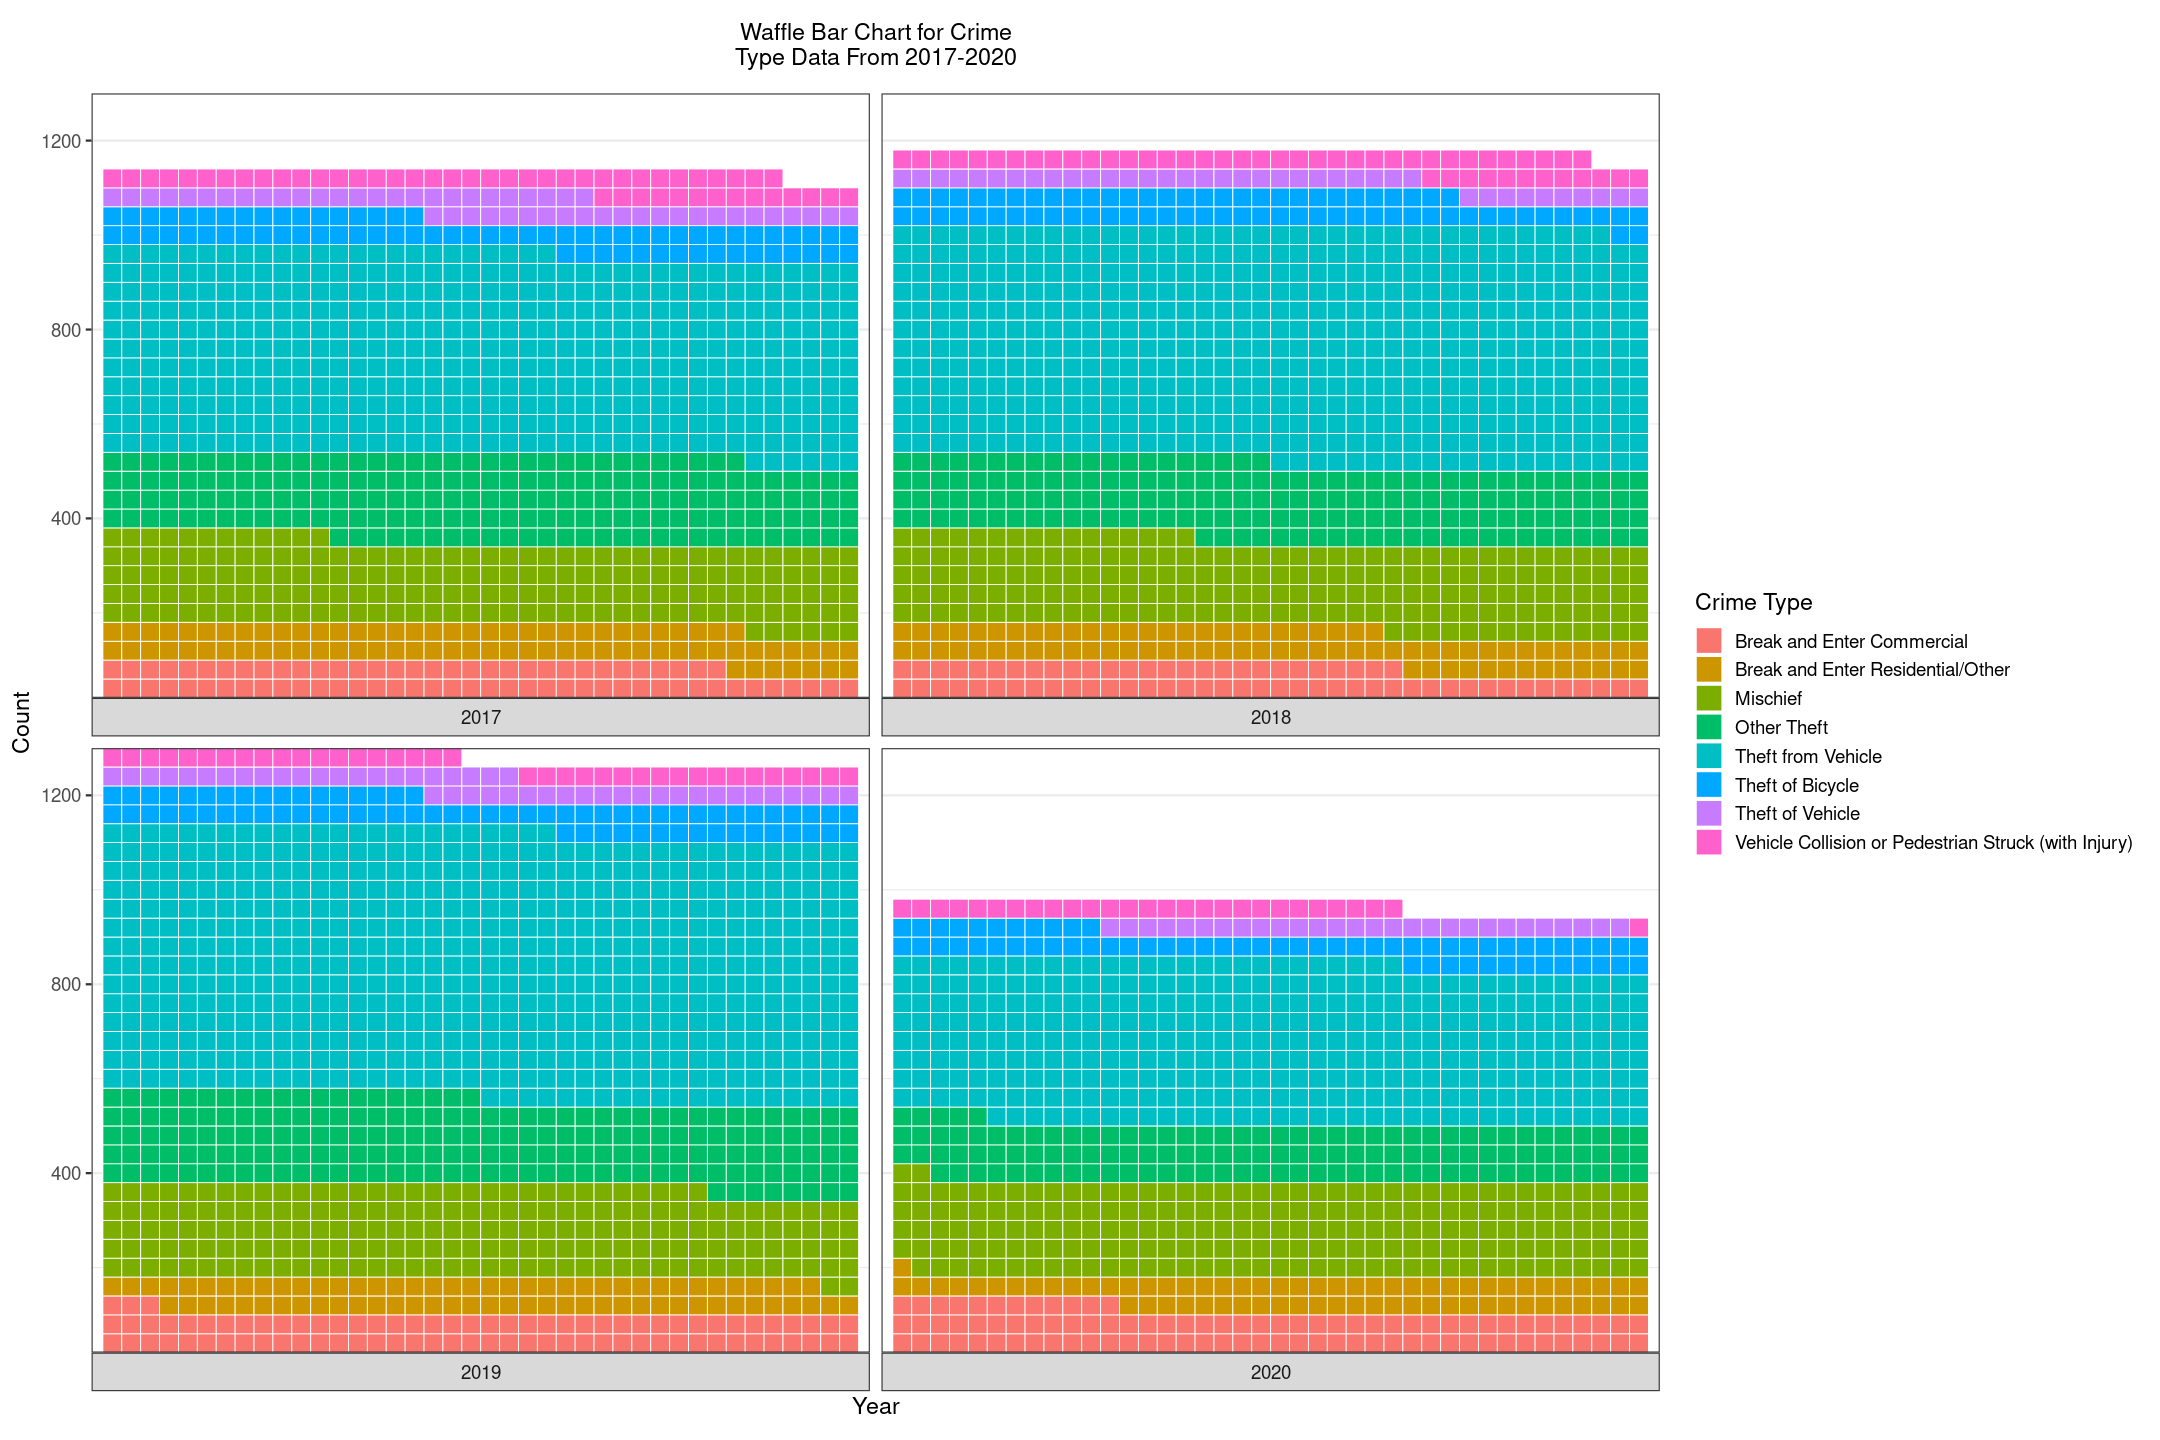

In [20]:
# 3. Let's look at the proportion of each crime committed over the years
waffle_plot <- crime_waffle %>%
    ggplot(aes(values = n, fill = type)) +
    geom_waffle(n_rows = 40, flip = TRUE, color = "white", size = 0.25) +
    facet_wrap(~year, nrow = 2, strip.position = "bottom") +
    scale_x_discrete() + 
    scale_y_continuous(labels = function(x) x * 40, # make this multiplier the same as n_rows
                       expand = c(0,0)) +
    labs(
        title = "Waffle Bar Chart for Crime\nType Data From 2017-2020\n",
        # subtitle = "A single square represents 30 crimes",
        x = "Year",
        y = "Count",
        fill = "Crime Type"
    ) +
    coord_equal() +
    theme_enhance_waffle() +
    theme(legend.position = "bottom") +
    theme_stat201(18, 12)
waffle_plot
create_caption(12, "A waffle plot depicting the proportion of each crime time by year.")

No trends are particularly obvious from the waffle plot, though we can see a clear reduction in crime overall in 2020, and it seems as though it is in large part due to a steep decline in "theft from vehicle" crimes.

Now, we can compute estimates of our parameter of interest across each of our different groups. In our case, this means computing the difference between the mean of the proportion of theft crimes committed across 2017 to 2019 and the proportion of theft crimes committed in 2020. Note the proportions are computed as the the total number of theft related crimes within a given neighborhood relative to the total of crimes that occurred within that neighborhood; hence the `group_by(...)` ahead of the computation of the proportion in the following code cell.

In [21]:
# Let's first compute the pre-COVID mean in each neighbourhood (merging 2017 to 2019)
before_pandemic_df_by_year <- crime_data %>%
    mutate(is_theft = as.numeric(type %in% theft_crimes)) %>%
    filter(year >= 2017 & year <= 2019) %>%
    group_by(neighbourhood, year) %>% # group by neighbourhood and year first!
    summarize(prop_theft = sum(is_theft) / n()) # compute theft crimes in neighbourhood / crimes in neighborhood

# View prop_theft by year (2017, 2018, 2019) and neighbourhood
# head(p_hat_pre_covid_by_year)

before_pandemic_df <- before_pandemic_df_by_year %>%
    group_by(neighbourhood) %>%
    summarize(prop_theft = mean(prop_theft)) %>%
    mutate(time = "Before pandemic") %>%
    mutate(time = as_factor(time))
head(before_pandemic_df)
create_caption(13, "A table of the proportions of thefts by period of time.")

`summarise()` has grouped output by 'neighbourhood'. You can override using the `.groups` argument.



neighbourhood,prop_theft,time
<fct>,<dbl>,<fct>
Fairview,0.6885614,Before pandemic
West End,0.7348163,Before pandemic
Central Business District,0.7525392,Before pandemic
Hastings-Sunrise,0.6449970,Before pandemic
Strathcona,0.5578307,Before pandemic
Grandview-Woodland,0.6233940,Before pandemic


[1] "Figure #13: A table of the proportions of thefts by period of time."


In [22]:
# Now let's get an estimate for the COVID mean by neighbourhood
during_pandemic_df <- crime_data %>%
    mutate(is_theft = as.numeric(type %in% theft_crimes)) %>%
    filter(year == 2020) %>%
    group_by(neighbourhood) %>%
    summarize(prop_theft = sum(is_theft) / n()) %>%
    mutate(time = "During pandemic") %>%
    mutate(time = as_factor(time))
head(during_pandemic_df)
create_caption(14, "Another table of the proportions of thefts by period of time.")

neighbourhood,prop_theft,time
<fct>,<dbl>,<fct>
Fairview,0.6194740,During pandemic
West End,0.6331310,During pandemic
Central Business District,0.6046934,During pandemic
Hastings-Sunrise,0.5693642,During pandemic
Strathcona,0.4385246,During pandemic
Grandview-Woodland,0.5506849,During pandemic


[1] "Figure #14: Another table of the proportions of thefts by period of time."


In [23]:
# Summarize in table
prop_diff_df <- during_pandemic_df %>%
    rename(during_prop_theft = prop_theft) %>%
    select(during_prop_theft) %>%
    cbind(before_pandemic_df) %>%
    mutate(prop_diff = during_prop_theft - prop_theft) %>%
    select(neighbourhood, prop_diff)

prop_diff_df
create_caption(15, "A table capturing the differences in the proportion of theft-related crime over time.")

,neighbourhood,prop_diff
,<fct>,<dbl>
1,Fairview,-0.069087446
2,West End,-0.101685330
3,Central Business District,-0.147845807
4,Hastings-Sunrise,-0.075632827
5,Strathcona,-0.119306097
6,Grandview-Woodland,-0.072709108
7,Mount Pleasant,-0.104412043
8,Sunset,-0.022212726
9,Kensington-Cedar Cottage,0.013052607


[1] "Figure #15: A table capturing the differences in the proportion of theft-related crime over time."


In [24]:
prop_diff_df_summary <- prop_diff_df %>%
    summarize(decreased = sum(prop_diff < 0),
              increased = sum(prop_diff > 0))

prop_diff_df_summary
create_caption(16, "A table showing the number of neighborhoods that had increases and decreases in theft-related crime.")

print(sprintf("%s%% neighbourhoods saw an increase in crime, while the other %s%% neighbourhoods saw a decrease in crime.", 
              format(round(prop_diff_df_summary$increased / nrow(prop_diff_df) * 100, 2), nsmall = 2), 
              format(round(prop_diff_df_summary$decreased / nrow(prop_diff_df) * 100, 2), nsmall = 2)))

decreased,increased
<int>,<int>
19,5


[1] "Figure #16: A table showing the number of neighborhoods that had increases and decreases in theft-related crime."
[1] "20.83% neighbourhoods saw an increase in crime, while the other 79.17% neighbourhoods saw a decrease in crime."


Note that a negative value indicates a _decrease_ in crime during 2020. Our initial data suggests that the proportion of theft-related crime has actually mostly _decreased_ since the pandemic began. While this is a good estimate for us to begin our analysis with, it's by no means sufficient to conclude upon; more as to why that is the case is discussed below.

## Methods

### Strengths

Our report uses data from the Vancouver Police Department to study trends in crime across select Vancouver neighborhoods. It is "trustworthy" in the sense that we will look to be careful at providing _ranges_ of our final answer, rather than solely point estimates. However, that alone isn't enough to guarantee an effective analysis. 

We're also using _kind-of_ blocking (or simply "grouping") in our analysis that aids our interpretation of the results. Crime has been linked to wealth (and more specifically, socioeconomic status, or SES) [[World Bank, 8]](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1745-9125.1999.tb00483.x), so we'll treat it as a blocking variable, and group our data by three neighborhoods that represent different levels of wealth; however, we do not ever randomly sample within those groups, as we're considering our data to already be a sample, so it's not exactly what "blocking" truly is. Regardless, this "grouping" step will help us draw more meaningful conclusions within our analysis. 

Finally, we're being careful to not simply compare the trend of crime between 2019 and 2020. Since our focus is COVID-19, we're not especially interested in the 1-year trend, but rather, how 2020 has deviated from the "norm." It is plausible that 2019 was an outlier, so "merging" the 3-year span of 2017 to 2019 should provide us a better sense of the general, recent crime levels in Vancouver.

### Limitations

Some could argue that many of the "petty" crimes we're interested in, like theft, largely go unreported. And while our analysis does indeed aim to provide an estimate from this sample of strictly reported crimes, arguing what makes a "fair" range is a hard question to answer. Countless factors affect whether or not a crime gets reported, and trust in police generally was found to be at a "record low" in August of 2020 [[New York Times, 10]](https://www.nytimes.com/2020/08/12/us/gallup-poll-police.html), and according to Statistics Canada, "less than half of Canadians thought their local police were doing a good job of being approachable and easy to talk to" [[Statistics Canada, 14]](https://www150.statcan.gc.ca/n1/pub/85-002-x/2020001/article/00014-eng.htm). Accounting for this variability, statistically, is arduous.

Furthermore, while our neighborhood selections do represent a fair amount of spread in the wealth of various Vancouver neighborhoods, they're by no means perfectly representative. Shaughnessy, for one, being at a rather high-end extreme of wealth, might be less useful in our analysis, as it doesn't really generalize to any kind of useful population outside of that specific neighborhood.

### Analysis

Of course, the plots and estimates provided above are _not_ sufficient for any stakeholder, such as the municipal government or the VPD themselves. Since we're working with a sample, we must report a range of plausible values, rather than a single point estimate. Thankfully, there are a few steps we can take to do this in different ways:

Firstly, we can produce a hypothesis test, where our null is that theft-related crime rates have _not_ changed:

$$H_0: \Delta{p} = 0$$

where $\Delta{p} = p_1 - p_2$ and

$p_1$ is the proportion of theft-related crime in 2020

$p_2$ is the proportion of theft-related crimes, on average, between 2017 and 2019, 

and thus $\Delta{p}$ is the difference in the proportion of theft-related crimes relative to all committed crimes (within a given neighborhood) between those two time periods.

Our alternative hypothesis is "that there has been some sort of change"; in this case, it's that there is a statistically significant difference in the amount of crime between these two time periods:

$$H_A: \Delta{p} \ne 0$$

We'll have to do a two-tailed, two-sample z-test and check if our sample difference in proportions falls within our significance level. We'll conduct our analysis with an alpha value of 5%. This is a relatively standard value to use and will allow us to gauge if our findings are significant, or if differences in proportions can instead be merely attributed to sampling variation instead.

Secondly, we can produce a confidence interval to report a range of plausible values alongside our difference in proportions statistic. We'll use two techniques, both bootstrapping (i.e., generating a bootstrapped sampling distribution) and asymptotics, to yield a range of values at a confidence level ("CL") of 95%.

(Note that two-tailed hypothesis tests and confidence intervals are practically equivalent at ${CL} = 1 - \alpha$, but doing both approaches is good for rigor and completeness, and allows us to use both bootstrapping and asymptotics.)

Along the way, we will be sure to visualize and interpret our results within the context of our problem. These techniques will also allow us to report something actually sufficient for a stakeholder: both a statistic and a range. This is at the core of inferential statistics.

## Results

As described in the analysis section, we will conduct three different analyses.

1. Hypothesis test with bootstrapping
2. Confidence interval with bootstraping
3. Hypothesis test with asymptotics
4. Confidence interval with asymptotics

We begin with our bootstrapped hypothesis test.

## Bootstrapping

We'll begin with a hypothesis test done via bootstrapping. To do so, we'll use the `infer` package. Conducting a hypothesis test using bootstrapping and `infer` requires the following steps:

1. Specify your response variable
2. Create your "null hypothesis"; in our case, we'll specify "independence," which is a short way of telling `infer` that the null hypothesis is that $\Delta{p} = 0$
3. We'll generate our null model through taking a bootstrap sample of our data; we'll use 1,000 repetitions, since that allows the code cell to complete in a reasonable amount of time, and will yield a more accurate P-value
4. We specify the value we want to calculate; again, in our case, it's a difference in proportions, shortened to `"diff in props"`

Before we're able to conduct the test however, we'll have to format our data to capture both whether a crime is theft-related, `is_theft`, and whether it occurred before 2020 or was during 2020, `period`. Let's begin by doing the necessary wrangling.

In [25]:
# The goal is the wrangling that follows is to add two columns to our data frame:
#   a) `is_theft`, whether or not a crime is theft-related
#   b) `period`, when the crime occured ("Before pandemic", "During pandemic")

crime_data_is_theft <- crime_data %>%
    mutate(is_theft = type %in% theft_crimes) %>% # check if in the list of crimes whitelisted as theft-related
    select(neighbourhood, year, is_theft) # select relevant columns

head(crime_data_is_theft, n = 3) # we've now successfully completed step (a)
tail(crime_data_is_theft, n = 3) 
create_caption(17, "Exploring further tidied crime data.")

neighbourhood,year,is_theft
<fct>,<dbl>,<lgl>
Fairview,2019,FALSE
West End,2019,FALSE
West End,2020,FALSE


neighbourhood,year,is_theft
<fct>,<dbl>,<lgl>
Mount Pleasant,2019,FALSE
Mount Pleasant,2018,FALSE
Mount Pleasant,2020,FALSE


[1] "Figure #17: Exploring further tidied crime data."


In [26]:
# As discussed, let's now add the `period` column

crime_data_processed <- crime_data_is_theft %>% # reuse dataframe from step (a)
    filter(year >= 2017 & year <= 2020) %>% # filter to our target years
    mutate(period = ifelse(year < 2020, 'Before pandemic', 'During pandemic')) %>% # since we've filtered already, we only need to check year < 2020 to know if it's pre-pandemic (or not)
    mutate(period = as.factor(period)) # convert to factor

head(crime_data_processed, n = 3) # we've now successfully completed step (b)
tail(crime_data_processed, n = 3)
create_caption(18, "Exploring even further tidied crime data.")



neighbourhood,year,is_theft,period
<fct>,<dbl>,<lgl>,<fct>
Fairview,2019,FALSE,Before pandemic
West End,2019,FALSE,Before pandemic
West End,2020,FALSE,During pandemic


neighbourhood,year,is_theft,period
<fct>,<dbl>,<lgl>,<fct>
Mount Pleasant,2019,FALSE,Before pandemic
Mount Pleasant,2018,FALSE,Before pandemic
Mount Pleasant,2020,FALSE,During pandemic


[1] "Figure #18: Exploring even further tidied crime data."


We now have our desired data frame. Before we conduct the hypothesis test, we'll also need to gather a list of all twenty four neighborhoods in the data set, as we'll have to iterate the hypothesis testing logic for each of these neighborhoods and append it to our data frame. (We did this earlier in our exploration, but the reminder should be helpful.)

In [27]:
neighbourhoods <- unique(crime_data$neighbourhood) # get all unique neighborhoods
print(neighbourhoods)

 [1] Fairview                  West End                 
 [3] Central Business District Hastings-Sunrise         
 [5] Strathcona                Grandview-Woodland       
 [7] Mount Pleasant            Sunset                   
 [9] Kensington-Cedar Cottage  Stanley Park             
[11] Shaughnessy               Marpole                  
[13] Oakridge                  Kitsilano                
[15] Victoria-Fraserview       Kerrisdale               
[17] West Point Grey           Riley Park               
[19] Arbutus Ridge             Renfrew-Collingwood      
[21] Killarney                 South Cambie             
[23] Dunbar-Southlands         Musqueam                 
24 Levels: Fairview West End Central Business District ... Musqueam


Now we have everything we need to conduct our hypothesis test using bootstrapping. There are many valid approaches here; we could use some combination of `group_by` and `summarize` to work through each neighborhood. Instead, we opted to initially construct an empty data frame, and successively bind our results to that data frame. Then, we loop through each of the neighborhoods in the previous vector.

Within the loop, the steps we must take are as follows:

1. Filter our wrangled crime data down to just containing reported crimes for our given neighborhood.
2. Create two data frames:
    * `pre_covid`, a data frame containing all reported crime for a given neighborhood that occurred from 2017 to 2019
    * `covid`, a data frame containing all reported crime for a given neighborhood that occurred during 2020
3. With each of these data frames, compute each proportion of theft-related crime relative to all crime; these are equal to "mean" of the `is_theft` column (treated as a numeric value instead of a boolean). This will effectively yield a proportion, as it will compute the sum of `1 + 1 + 0 + 1...` divided by the size of the data frame.
4. Compute our observed difference in proportions, `obs_diff_in_props`, which is our test statistic.
5. Conduct the infer workflow, generating our "null model" using 1,000 bootstrapped sample repetitions
6. Compute the probability of seeing our test statistic under the null model, the P-value
7. Format the resulting data into a data frame, and bind it to our `results` data frame

Interpretations of the P-value are saved for a subsequent code cell, where we'll compare our P-values to our significance level, 5%.

Our final data frame will take on the following shape:

| Column | Description |
|-:|-:|
| `neighbourhood` | The neighbourhood the crimes took place in. |
| `past_prop` | The proportion of reported, theft-related crimes to all reported crimes from 2017 to 2019.  |
| `current_prop` | The proportion of reported, theft-related crimes to all reported crimes in 2020.  |
| `diff_in_props` | Our test statistic, equal to the difference of `current_prop` and `past_prop`. |
| `p_value` | The likelihood of observing our test statistic under the null model, where there is no difference in the proportion of theft-related crimes.. |

<p style="text-align: center;">Figure 19: Showing the form of our final data for the bootstrapping workflow.</p>

To further illustrate this workflow, we'll do one neighborhood on its own and visualize the null model, just to get a better sense of what's happening within the loop. We'll use Marpole as an example.

[1] "Figure #19: Visualizing the p-value on a single null distribution for Dunbar-Southlands."
[1] "Our p-value is 0.080000"


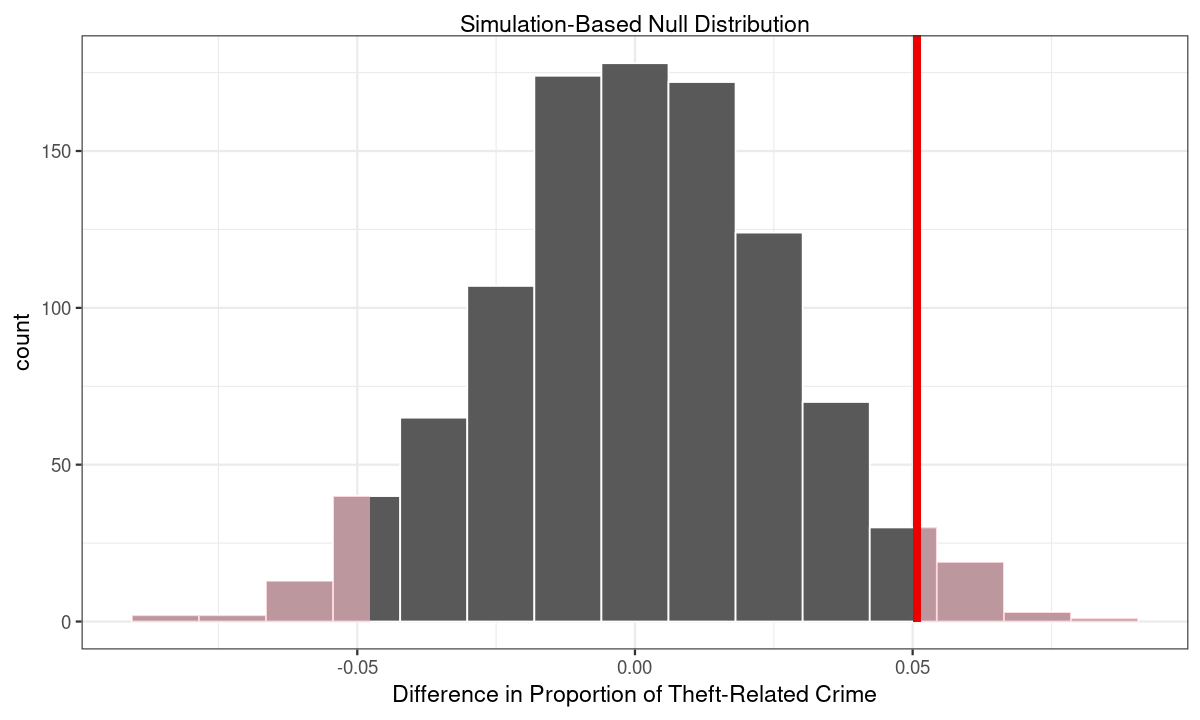

In [28]:
# Choose as neighbourhood to use 
n <- "Dunbar-Southlands"

# 1. Filter data down to just this neighbourhood
neighbourhood_data <- crime_data_processed %>% 
    filter(neighbourhood == n)

# 2., 3., 4. done with a "shortcut" using infer
obs_diff_in_props <- neighbourhood_data %>%
    specify(is_theft ~ period, success = "TRUE") %>% # specify our response variable
    calculate(stat = "diff in props", order = c("During pandemic", "Before pandemic")) # compute the "diff in props" for each

# 5. Conduct the infer workflow
neighbourhood_infer <- neighbourhood_data %>%
    specify(is_theft ~ period, success = "TRUE") %>% # specify our response variable
    hypothesise(null = "independence") %>% # i.e., that the change in proprotion is 0
    generate(reps = 1000, type = "permute") %>% # generate 1,000 bootstrap samples for our null model
    calculate(stat = "diff in props", order = c("During pandemic", "Before pandemic")) # compute the "diff in props" for each

# 6. (Skipped! We don't need the P-value here yet.)
# 7. (Skipped! We don't need to append to anything just yet.)

neighbourhood_infer_vis <- neighbourhood_infer %>% 
   visualize() + 
   shade_p_value(obs_stat = obs_diff_in_props, direction = "two_sided") +
   xlab("Difference in Proportion of Theft-Related Crime") + 
   theme_stat201(10, 6)

neighbourhood_infer_vis
create_caption(19, "Visualizing the p-value on a single null distribution for Dunbar-Southlands.")
print(sprintf("Our p-value is %f", get_p_value(neighbourhood_infer, obs_diff_in_props, direction = "two_sided")))

In [29]:
set.seed(SEED) # set our seed to the global seed for this notebook

# Suppress p-value = 0 warnings; to reduce this, we could opt for more repetitions
# bu that is not feasible given the number of neighbourhoods (24) we're targeting! 
oldw <- getOption("warn")
options(warn = -1) # Suppress "unable to translate '<U+00C4>' to native encoding" error messages

# Initialize our empty data frame with our desired columns; 
# see the Markdown table above for a description of the columns
columns <- c("neighbourhood", "past_prop", "current_prop", "diff_in_props", "p_value")
neighbourhoods_bootstrap_result <- data.frame(matrix(ncol = length(columns), nrow=0))
names(neighbourhoods_bootstrap_result) <- columns # assign column names

# For every neighbourhood
for (n in neighbourhoods) {
    # 1. Filter data down to just this neighbourhood
    neighbourhood_data <- crime_data_processed %>% 
        filter(neighbourhood == n)
    
    # 2. Create two data frames to separate pre-pandemic and during-pandemic crime
    pre_covid <- neighbourhood_data %>%
        filter(period == "Before pandemic")
    covid <- neighbourhood_data %>%
        filter(period  == "During pandemic")
    
    # 3. Compute proportions of theft-related crime within each data frame, using `mean`
    pre_covid_prop <- mean(as.numeric(pre_covid$is_theft))
    covid_prop <- mean(as.numeric(covid$is_theft))
    
    # 4. Compute our test statistic, the difference in proportions for this neighbourhood
    obs_diff_in_props <- covid_prop - pre_covid_prop
    
    # 5. Conduct the infer workflow
    neighbourhood_infer <- neighbourhood_data %>%
        specify(is_theft ~ period, success = "TRUE") %>% # specify our response variable
        hypothesise(null = "independence") %>% # i.e., that the change in proprotion is 0
        generate(reps = 1000, type = "permute") %>% # generate 1,000 bootstrap samples for our null model
        calculate(stat = "diff in props", order = c("During pandemic", "Before pandemic")) # compute the "diff in props" for each
    
    # 6. Compute the p-value, using our test statistic for this neighbourhood
    # NOTE: the test is two-tailed!
    p_value <- neighbourhood_infer %>% get_p_value(obs_diff_in_props, direction = "two_sided") %>% pull()
    
    # 7. Format and append our observed result to our `neighbourhoods_bootstrap_result` data frame
    new_obs <- data.frame(n, pre_covid_prop, covid_prop, obs_diff_in_props, p_value)
    names(new_obs) <- columns
    
    # NOTE: this is line that actually does the "appending"; rbind binds rows by common columns
    neighbourhoods_bootstrap_result <- rbind(neighbourhoods_bootstrap_result, new_obs)
}

# Reset warning messages
options(warn = oldw)

# Explore our results in `neighbourhoods_bootstrap_result`
head(neighbourhoods_bootstrap_result, n = 3)
tail(neighbourhoods_bootstrap_result, n = 3)
create_caption(20, "Exploring out bootstrapped result.")

,neighbourhood,past_prop,current_prop,diff_in_props,p_value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Fairview,0.6891537,0.6194740,-0.06967969,0
2,West End,0.7351588,0.6331310,-0.10202785,0
3,Central Business District,0.7533982,0.6046934,-0.14870486,0


,neighbourhood,past_prop,current_prop,diff_in_props,p_value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
22,South Cambie,0.6170412,0.6040609,-0.01298028,0.688
23,Dunbar-Southlands,0.5390335,0.5897436,0.05071013,0.066
24,Musqueam,0.5111111,0.1739130,-0.33719807,0.014


[1] "Figure #20: Exploring out bootstrapped result."


We now need to interpret these P-values within the context of the problem. Let's first add a column that indicates whether or not we should reject each P-value at a 5% significance level.

In [30]:
# Add on whether or not we should reject the P-value
neighbourhoods_bootstrap_result <- neighbourhoods_bootstrap_result %>% 
    mutate(reject5 = p_value < 0.05)

neighbourhoods_bootstrap_result
create_caption(21, "Exploring out bootstrapped result with interpretations of the P-value")

neighbourhood,past_prop,current_prop,diff_in_props,p_value,reject5
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
Fairview,0.6891537,0.6194740,-0.069679692,0.000,TRUE
West End,0.7351588,0.6331310,-0.102027854,0.000,TRUE
Central Business District,0.7533982,0.6046934,-0.148704859,0.000,TRUE
Hastings-Sunrise,0.6451613,0.5693642,-0.075797128,0.000,TRUE
Strathcona,0.5577118,0.4385246,-0.119187188,0.000,TRUE
Grandview-Woodland,0.6237392,0.5506849,-0.073054262,0.000,TRUE
Mount Pleasant,0.6768553,0.5719462,-0.104909124,0.000,TRUE
Sunset,0.5896720,0.5651163,-0.024555738,0.224,FALSE
Kensington-Cedar Cottage,0.6043016,0.6161616,0.011860044,0.440,FALSE


[1] "Figure #21: Exploring out bootstrapped result with interpretations of the P-value"


We'll now do a brief interpretation of the results. Since we're doing our analysis across all of the twenty four available neighborhoods, we have twenty four separate hypotheses tests to interpret; to make this more digestible, we'll write a "general" interpretation and discuss our interpretation of the results in the discussion section.

In general, if `reject5` is `TRUE`, indicating we _should_ reject the null hypothesis at a 5% significance level, this means there was indeed a statistically significant difference in the proportion of theft-related crime between 2020 and the average of the proportion of the years 2017 to 2019. For example, in the the Kitsilano neighborhood, our P-value was just 0.02, or 2%. This indicates that under the null model, we had a 2% chance of observing a value as extreme or more extreme (in either the left or right tail, since the test was two-tailed) than our test statistic; since this is smaller than the threshold of P-values we are interested in, 5%, we do consider it significant. We conclude there is a statistically significant difference in the proportion of theft-related crime in 2020 compared to the mean of the past three years.

Likewise, in general, if `reject5` is `FALSE`, indicating we _should not_ reject the null hypothesis at a 5% significance level, this means there was not a statistically significant difference in proportions. For example, in the the Renfrew-Collingwood neighborhood, our P-value was 0.06, or 6%. This indicates that under the null model, we had a 6% chance of observing a value as extreme or more extreme (in either the left or right tail, since the test was two-tailed) than our test statistic; since this is larger than the threshold of P-values we are interested in, 5%, we don't consider it significant. We conclude there was no statistically significant in theft-related crime in 2020.
 
We can quickly compute the total numbers of rejected and non-rejected neighborhoods.

In [31]:
# Compute summary statistics for our bootstrap result
neighbourhoods_bootstrap_result_summary <- neighbourhoods_bootstrap_result %>%
    summarize(rejected = sum(reject5),
              non_rejected = sum(!reject5),
              n = n())

neighbourhoods_bootstrap_result_summary
create_caption(22, "A table showing the number of rejected and non-rejected null hypotheses.")

print(sprintf("%s%% neighbourhoods did see a statistically significant change in the proportion of theft-related crime, while the other %s%% neighbourhoods did not.", 
              format(round(neighbourhoods_bootstrap_result_summary$rejected / neighbourhoods_bootstrap_result_summary$n * 100, 2), nsmall = 2), 
              format(round(neighbourhoods_bootstrap_result_summary$non_rejected / neighbourhoods_bootstrap_result_summary$n * 100, 2), nsmall = 2)))

rejected,non_rejected,n
<int>,<int>,<int>
11,13,24


[1] "Figure #22: A table showing the number of rejected and non-rejected null hypotheses."
[1] "45.83% neighbourhoods did see a statistically significant change in the proportion of theft-related crime, while the other 54.17% neighbourhoods did not."


In the discussion, we'll consider all twenty four tests together, and see what, if any, trends we notice, especially considering the difference average income levels of each neighborhood. 

### Confidence Intervals via Bootstrapping

Similarly, we could also construct confidence intervals via bootstrapping; this, in a way, "inverts" our analysis. Instead of beginning from an assumption of the true value, we'll use our sample to compute a range of plausible values.

Just like we did for hypothesis testing, we'll first construct a basic confidence interval for one neighborhood; then, we'll do it for all twenty four. Additionally, we'll visualize which confidence intervals capture our null value of zero; this will suggest how many neighborhoods do indeed show a statistically significant difference in the proportion of theft-related crime. (Note that a two-tailed hypothesis test, as we did above, is effectively the same as a confidence interval; the interpretation lines up exactly, we just consider if the interval captures zero instead.)

Our process is much more straightforward than before as well, which is a nice bonus:

1. Begin by filtering down the `crime_data_processed` data frame to just the neighborhood we're interested in 
2. Generate a bootstrap sample for 1,000 repetitions
3. Construct the confidence interval by calling `get_ci(...)`
4. Append our findings to the `results` data frame

We'll handle the logic of whether or not an interval captured zero later in the code.

In [32]:
# Choose as neighbourhood to use 
n <- "Dunbar-Southlands"

# 1. Filter data down to just this neighbourhood
neighbourhood_data <- crime_data_processed %>% 
    filter(neighbourhood == n)

# Generate our bootstrap sample
neighbourhood_bootstrapped <- neighbourhood_data %>% 
    specify(is_theft ~ period, success = "TRUE") %>% # specify our response variable
    generate(reps = 1000, type = "bootstrap") %>% # generate 1,000 bootstrap samples for our null model
    calculate(stat = "diff in props", order = c("During pandemic", "Before pandemic")) # compute the "diff in props" for each

# 5. Conduct the infer workflow
neighbourhood_ci_95 <- neighbourhood_bootstrapped %>% 
    get_ci(level = 0.95, type = "percentile")

head(neighbourhood_ci_95)
create_caption(23, "The confidence interval, using bootstrapping, for Dunbar-Southlands")

lower_ci,upper_ci
<dbl>,<dbl>
-0.002856118,0.1057797


[1] "Figure #23: The confidence interval, using bootstrapping, for Dunbar-Southlands"


This interval does captured the value of 0, as `lower_ci` is less than 0 and `upper_ci` is greater than 0. This means that Dunbar-Southlands would be considered to show no statistically significant change.

Let's try this process now on each neighborhood separately.

In [33]:
columns <- c("neighbourhood", "lower_ci", "upper_ci")
neighborhoods_bootstrap_cis <- data.frame(matrix(ncol = length(columns), nrow=0))
names(neighborhoods_bootstrap_cis) <- columns # assign column names

for (n in neighbourhoods) {
    # 1. Filter data down to just this neighbourhood
    neighbourhood_data <- crime_data_processed %>% 
        filter(neighbourhood == n)

    # 2. Generate our bootstrap sample
    neighbourhood_bootstrapped <- neighbourhood_data %>% 
        specify(is_theft ~ period, success = "TRUE") %>% # specify our response variable
        generate(reps = 1000, type = "bootstrap") %>% # generate 1,000 bootstrap samples for our null model
        calculate(stat = "diff in props", order = c("During pandemic", "Before pandemic")) # compute the "diff in props" for each

    # 3. Get our confidence interval
    neighbourhood_ci_95 <- neighbourhood_bootstrapped %>% 
        get_ci(level = 0.95, type = "percentile")
    
    # 4. Format and append our observed result to our `neighborhoods_bootstrap_cis` data frame
    new_obs <- data.frame(n, neighbourhood_ci_95$lower_ci, neighbourhood_ci_95$upper_ci)
    names(new_obs) <- columns
    
    # NOTE: this is line that actually does the "appending"; rbind binds rows by common columns
    neighborhoods_bootstrap_cis <- rbind(neighborhoods_bootstrap_cis, new_obs)
}

# Append the `captured` boolean is lower_ci and upper_ci contain 0, when treated as an interval
intervals_captured_95 <- neighborhoods_bootstrap_cis %>% 
    mutate(captured = (lower_ci <= 0 & 0 <= upper_ci))

# Explore our results
head(intervals_captured_95, n = 3)
tail(intervals_captured_95, n = 3)
create_caption(24, "Exploring all confidence intervals constructed via bootstapping")

,neighbourhood,lower_ci,upper_ci,captured
,<chr>,<dbl>,<dbl>,<lgl>
1,Fairview,-0.09534229,-0.04366537,FALSE
2,West End,-0.12538623,-0.08151268,FALSE
3,Central Business District,-0.16111815,-0.13610200,FALSE


,neighbourhood,lower_ci,upper_ci,captured
,<chr>,<dbl>,<dbl>,<lgl>
22,South Cambie,-0.069029038,0.04006276,TRUE
23,Dunbar-Southlands,-0.002710485,0.10775335,TRUE
24,Musqueam,-0.545885174,-0.11523241,FALSE


[1] "Figure #24: Exploring all confidence intervals constructed via bootstapping"


We now have examples of intervals which both do and do not captured the value of 0; again, when the interval does not capture the value of 0, we would in turn reject a "supposed" null hypothesis that there is no difference in the proportions at a significance level of $\alpha = 1 - \text{CL}$, where "CL" stands in for our confidence level.

Let's now visualize our results for all neighborhoods.

[1] "Figure #25: Visualizing confidence intervals constructed via bootstapping"


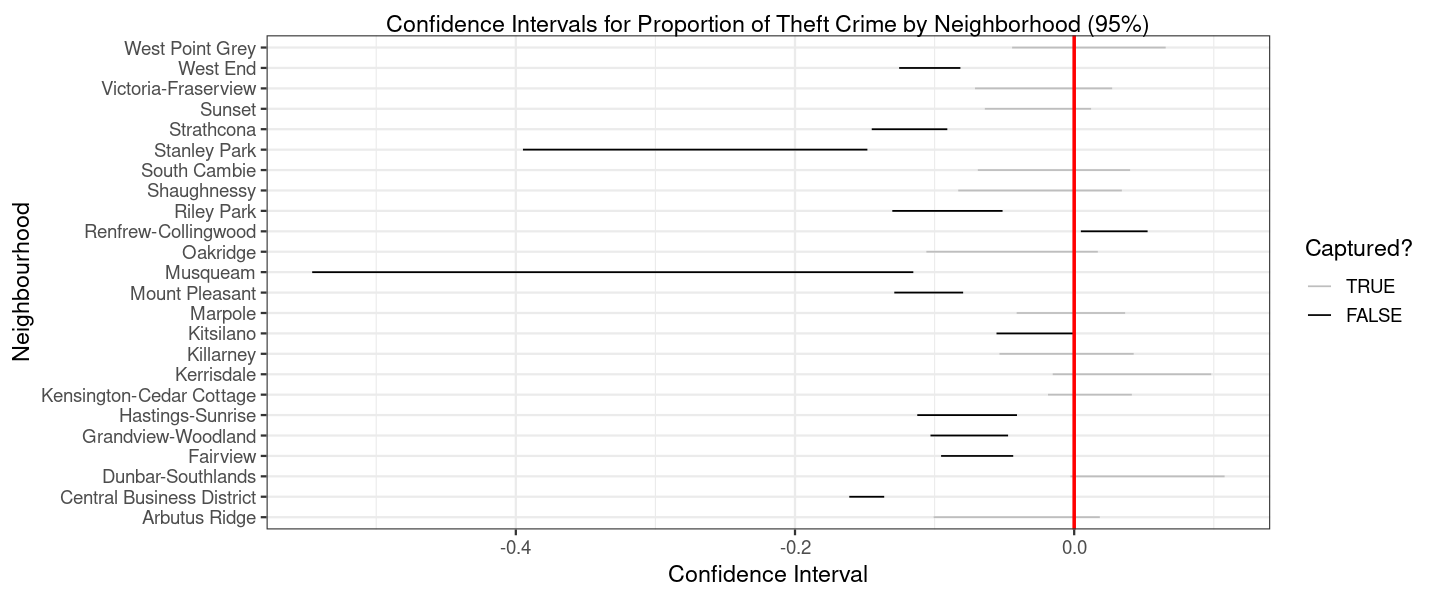

In [34]:
# Visualize whether or not our confidence intervals captured the true value
many_ci_plot_95 <- intervals_captured_95 %>%
    ggplot() +
    scale_colour_manual(breaks = c("TRUE", "FALSE"),
                        values = c("grey", "black")) +
    geom_segment(aes(x = lower_ci,
                     xend = upper_ci,
                     y = neighbourhood,
                     yend = neighbourhood,
                     color = captured)) +
    geom_vline(xintercept = 0, colour = "red", size = 1) +
    labs(title = "Confidence Intervals for Proportion of Theft Crime by Neighborhood (95%)",
         y = "Neighbourhood",
         x = "Confidence Interval",
         colour = "Captured?") +
    theme_stat201()

many_ci_plot_95
create_caption(25, "Visualizing confidence intervals constructed via bootstapping")

It appears that though most neighborhoods captured the value of zero, many do not; the Musqueam neighborhood is notable here as well, as it's extremely small sample size, relative to other neighborhoods, led to a very wide confidence interval. We also observe that the Central Business District has had a sharp change in the proportion of theft related crime, as it's one of the smallest intervals observed yet it is very far from containing zero.

## Asymptotics

We'll now conduct hypothesis testing based on results from the Central Limit Theorem (CLT). To conduct a two-sample z-test of prortions, we'll rely on the following formula:

$$ Z = \frac{(\hat{p_1} - \hat{p_2} - 0)}{\sqrt(\hat{p_{\text{pooled}}} \cdot (1 - \hat{p_{\text{pooled}}} \cdot (\frac{1}{n_1} + \frac{1}{n_2}))} $$

where

$Z$ is the standardized z-score, to be used as our normalized test statistic

$\hat{p_1}$ is the proportion of theft-related crime relative to all crime in 2020

$\hat{p_2}$ is the proportion of theft-related crime relative to all crime on average from 2017 to 2019

$\hat{p_{\text{pooled}}}$ is the pooled proportion of and $\hat{p_1}$ and $\hat{p_2}$

${n_1}$ is the total number of crimes in 2020 (for a given neighborhood)

${n_2}$ is the number of crimes on average from 2017 to 2019 (for a given neighborhood)

It looks like we'll have to filter out the Museqeum neighborhood for this portion of our analysis.

Let's first define a helper function that will, from our processed crime data, compute the needed summary statistics for a given neighbourhood during a needed time period. The summary statistics we need to compute a difference in proportions are the proportion of theft-related crime to all crime, `prop`, the total number of theft related crimes, `s` (for "success"), and the total number of crimes, `n`. These values will be used in our calculation of our Z-score.

Note that in lieu of the following helper function, we could've alternatively used the `group_by` and `summarize` pattern to achieve a similar workflow.

In [35]:
set.seed(SEED)

# Compute needed summary statistics for a given neighborhood `n`, for before or after the pandemic, `p`
get_crime_data_summary <- function(n, p) {
    crime_data_filtered <- crime_data_processed %>% 
        filter(neighbourhood == n) %>%
        filter(period == p)

    crime_data_summary <- crime_data_filtered %>%
        summarize(prop = mean(is_theft),
                  s = sum(is_theft),
                  n = n())

    return (crime_data_summary)
}

head(get_crime_data_summary("Kitsilano", "Before pandemic"))
create_caption(26, "Showing example call to summary data helper function")

prop,s,n
<dbl>,<int>,<int>
0.6463512,3224,4988


[1] "Figure #26: Showing example call to summary data helper function"


We can now compute our "before pandemic" summary statistics.

In [36]:
# Initialize an empty tibble, as before
crime_data_past_summary <- tibble(neighbourhood = "", prop = 0, s = 0, n = 0)

# For every neighbourhood available
for (neighbourhood in neighbourhoods) {
    # Call helper function
    stats <- get_crime_data_summary(neighbourhood, "Before pandemic")
    
    # Pull the data we need
    prop <- pull(stats[1])
    s <-  pull(stats[2])
    n <- pull(stats[3])
    
    # Append a row to our resulting data frame
    crime_data_past_summary <- add_row(crime_data_past_summary, neighbourhood = neighbourhood, prop = prop, s = s, n = n)
}

crime_data_past_summary <- crime_data_past_summary[-1,]

# Explore our results
head(crime_data_past_summary, n = 3)
tail(crime_data_past_summary, n = 3)
create_caption(27, "Exploring summarized data for before the pandemic")

neighbourhood,prop,s,n
<chr>,<dbl>,<dbl>,<dbl>
Fairview,0.6891537,3933,5707
West End,0.7351588,6712,9130
Central Business District,0.7533982,24997,33179


neighbourhood,prop,s,n
<chr>,<dbl>,<dbl>,<dbl>
South Cambie,0.6170412,659,1068
Dunbar-Southlands,0.5390335,725,1345
Musqueam,0.5111111,23,45


[1] "Figure #27: Exploring summarized data for before the pandemic"


We can again re-use our helper to do this kind of analysis for our 2020, or "during pandemic," data.

In [37]:
# Initialize an empty tibble, as before
crime_data_during_summary <- tibble(neighbourhood = "", prop = 0, s = 0, n = 0)

# For every neighbourhood available
for (neighbourhood in neighbourhoods) {
    # Call helper function
    stats <- get_crime_data_summary(neighbourhood, "During pandemic")
    
    # Pull the data we need
    prop <- pull(stats[1])
    s <-  pull(stats[2])
    n <- pull(stats[3])
    
    # Append a row to our resulting data frame
    crime_data_during_summary <- add_row(crime_data_during_summary, neighbourhood = neighbourhood, prop = prop, s = s, n = n)
}

crime_data_during_summary <- crime_data_during_summary[-1,]

# Explore our results
head(crime_data_during_summary, n = 3)
tail(crime_data_during_summary, n = 3)
create_caption(28, "Exploring summarized data for during the pandemic")

neighbourhood,prop,s,n
<chr>,<dbl>,<dbl>,<dbl>
Fairview,0.6194740,1107,1787
West End,0.6331310,1460,2306
Central Business District,0.6046934,4664,7713


neighbourhood,prop,s,n
<chr>,<dbl>,<dbl>,<dbl>
South Cambie,0.6040609,238,394
Dunbar-Southlands,0.5897436,253,429
Musqueam,0.1739130,4,23


[1] "Figure #28: Exploring summarized data for during the pandemic"


Finally, let's combine the data.

In [38]:
# We'll first need to the rename our column names to prevent collisions
crime_data_past_summary_tidy <- crime_data_past_summary %>%
    rename(past_prop = prop,
           past_s = s,
           past_n = n)
crime_data_during_summary_tidy <- crime_data_during_summary %>%
    rename(curr_prop = prop,
           curr_s = s,
           curr_n = n)

# Now, we left_join our two data frames (combining them by common neighbourhood names)
crime_data_merged <- left_join(crime_data_past_summary_tidy, crime_data_during_summary_tidy, by = "neighbourhood")

Note that for our application of the CLT to be valid, we'll also need to check a few key assumptions:

* the sample is randomly drawn; no indication the sample is not random, seeing as its a portion of all crime in Vancouver
* the data are chosen independently of each other; again, nothing from the VPD's data set description indicates the data are dependent
* the sample size is "big enough" $n \cdot p \geq 10$ and $n \cdot q \geq 10$; we'll verify this for both past and current data below


In [39]:
# Merge our crime data and add a variable to verify if we met the CLT conditions
crime_data_merged <- crime_data_merged %>%
    mutate(met = past_n * past_prop >= 10 & past_n * (1 - past_prop) >= 10 & curr_n * curr_prop >= 10 & curr_n * (1 - curr_prop) >= 10)
crime_data_merged
create_caption(29, "Showing whether or not merged data meets CLT assumptions")

neighbourhood,past_prop,past_s,past_n,curr_prop,curr_s,curr_n,met
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
Fairview,0.6891537,3933,5707,0.6194740,1107,1787,TRUE
West End,0.7351588,6712,9130,0.6331310,1460,2306,TRUE
Central Business District,0.7533982,24997,33179,0.6046934,4664,7713,TRUE
Hastings-Sunrise,0.6451613,2500,3875,0.5693642,591,1038,TRUE
Strathcona,0.5577118,3305,5926,0.4385246,749,1708,TRUE
Grandview-Woodland,0.6237392,3463,5552,0.5506849,804,1460,TRUE
Mount Pleasant,0.6768553,4916,7263,0.5719462,1105,1932,TRUE
Sunset,0.5896720,1690,2866,0.5651163,486,860,TRUE
Kensington-Cedar Cottage,0.6043016,2613,4324,0.6161616,793,1287,TRUE


[1] "Figure #29: Showing whether or not merged data meets CLT assumptions"


It looks like the Musqueam neighborhood will not be valid for the rest of our analysis.

In [40]:
# Filter out the Musqueam neighborhood
crime_data_merged_clt <- crime_data_merged %>%
    filter(neighbourhood != "Musqueam")

From a quick glance at the data, there seems to be a difference with the proportion of thefts between 2020 and the previous years.  In fact, quite a few seem to have a decrease in crime rate, as we saw in our initial exploration as well.

We can now compute our test statistic as before, and determine our P-value. The full workflow for conducting our hypothesis test will be as follows:

1. Compute the pooled proportion for each neighborhood
2. Compute the Z-score for each neighborhood
3. Compute the P-value using `pnorm(...)`, at R built-in
4. Determine whether or not we should reject the null hypothesis, based on a significance level of 5%

In [41]:
# 1. Compute the pooled proportion
crime_data_pooled <- crime_data_merged_clt %>%
    mutate(pooled_prop = ((curr_n * curr_prop) + (past_n * past_prop)) / (curr_n + past_n))

# 2., 3., 4., "Conduct the test"
p0_diff <- 0 
crime_data_stat <- crime_data_pooled %>% 
    mutate(stat = (curr_prop - past_prop - p0_diff) / sqrt(pooled_prop * (1 - pooled_prop) * (1 / curr_n + 1 / past_n)),
           # could just as well be done prop.test(...) %>% tidy(...)
           p_value = 2 * pnorm(-abs(stat), lower.tail = TRUE), # two-tailed test; normalize stat with -abs(...) so lower.tail=FALSE always works
           reject5 = p_value < 0.05)

head(crime_data_stat, n = 3)
tail(crime_data_stat, n = 3)
create_caption(30, "Exploring result of asymptotics hypothesis testing")

neighbourhood,past_prop,past_s,past_n,curr_prop,curr_s,curr_n,met,pooled_prop,stat,p_value,reject5
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<lgl>
Fairview,0.6891537,3933,5707,0.6194740,1107,1787,TRUE,0.6725380,-5.477429,4.315508e-08,TRUE
West End,0.7351588,6712,9130,0.6331310,1460,2306,TRUE,0.7145855,-9.693522,3.212542e-22,TRUE
Central Business District,0.7533982,24997,33179,0.6046934,4664,7713,TRUE,0.7253497,-26.356367,4.338609e-153,TRUE


neighbourhood,past_prop,past_s,past_n,curr_prop,curr_s,curr_n,met,pooled_prop,stat,p_value,reject5
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<lgl>
Killarney,0.6045561,1035,1712,0.5986395,264,441,TRUE,0.6033442,-0.2264818,0.82082672,FALSE
South Cambie,0.6170412,659,1068,0.6040609,238,394,TRUE,0.6135431,-0.4522423,0.65109442,FALSE
Dunbar-Southlands,0.5390335,725,1345,0.5897436,253,429,TRUE,0.5512965,1.8388037,0.06594406,FALSE


[1] "Figure #30: Exploring result of asymptotics hypothesis testing"


Again, we can quickly summarize this data and see what proportion of neighborhood were rejected or not.

In [42]:
# Produce summary statistics for our asymptotics hypothesis test
crime_data_stat_summary <- crime_data_stat %>%
    summarize(rejected = sum(reject5),
              non_rejected = sum(!reject5),
              n = n())

crime_data_stat_summary
create_caption(31, "A table containing the number of rejected and non-rejected null hypotheses")

print(sprintf("Using asymptotics %s%% neighbourhoods did see a statistically significant change in the proportion of theft-related crime, while the other %s%% neighbourhoods did not.", 
              format(round(crime_data_stat_summary$rejected / crime_data_stat_summary$n * 100, 2), nsmall = 2), 
              format(round(crime_data_stat_summary$non_rejected / crime_data_stat_summary$n * 100, 2), nsmall = 2)))


rejected,non_rejected,n
<int>,<int>,<int>
11,12,23


[1] "Figure #31: A table containing the number of rejected and non-rejected null hypotheses"
[1] "Using asymptotics 47.83% neighbourhoods did see a statistically significant change in the proportion of theft-related crime, while the other 52.17% neighbourhoods did not."


One thing to note is that a large majority of the neighbourhoods, either with the Null-Hypothesis rejected or not, seems to have a decrease of reported thefts in 2020 compared to the past year.  


### Confidence Intervals via Asymptotics

Finally, this brings us to the last stage of our analysis. Just as we did with bootstrapping, we'll also construct a 95% confidence interval using classical techniques.

This time, we'll need to compute the following:

$$\Delta{\hat{p}} = \hat{p_1} - \hat{p_2}$$

as we've seen before, the difference in proportions, and

$$SE_{\hat{p_1} - \hat{p_2}} = \sqrt{(\frac{\hat{p_1} \cdot (1 - \hat{p_1})}{n_1}) + \frac{(\hat{p_2} \cdot (1 - \hat{p_2})}{n_2}) } $$ 

where $SE_{\hat{p_1} - \hat{p_2}}$ is the standard error in the difference of proportions.

Note the definitions for $\hat{p_i}$ and $n_i$ carry forward from before. 

We'll also need to check our assumptions to apply to CLT. Note these are the same assumptions we before!

* the sample is randomly drawn; no indication the sample is not random, seeing as its a portion of all crime in Vancouver
* the data are chosen independently of each other; again, nothing from the VPD's data set description indicates the data are dependent
* the sample size is "big enough" $n \cdot p \geq 10$ and $n \cdot q \geq 10$; we'll verify this for both past and current data below

We'll use our data set from before, `crime_data_merged_clt`, to again filter out the Musqueam neighborhood.

Now that those conditions are met, we can apply the CLT. Let's compute the confidence interval based on Central Limit Theorem.

In [43]:
# Compute the needed statistics from above
crime_data_ci <- crime_data_merged_clt %>%
    mutate(diff_prop = curr_prop - past_prop,
           diff_prop_se = sqrt((curr_prop * (1 - curr_prop) / curr_n) + (past_prop * (1 - past_prop) / past_n)))

# Compute the interval using qnorm
crime_data_ci_95 <- crime_data_ci %>%
    mutate(lower_ci = qnorm(0.025, diff_prop, diff_prop_se),
           upper_ci = qnorm(0.975, diff_prop, diff_prop_se)) %>%
    select(neighbourhood, lower_ci, upper_ci)

# Indicate whether or not an interval captued 0
intervals_captured_95 <- crime_data_ci_95 %>% 
    mutate(captured = (lower_ci <= 0 & 0 <= upper_ci))

head(intervals_captured_95, n = 3)
tail(intervals_captured_95, n = 3)
create_caption(32, "Exploring confidence intervals generated via asymptotics")

neighbourhood,lower_ci,upper_ci,captured
<chr>,<dbl>,<dbl>,<lgl>
Fairview,-0.09519298,-0.04416640,FALSE
West End,-0.12368100,-0.08037471,FALSE
Central Business District,-0.16056083,-0.13684888,FALSE


neighbourhood,lower_ci,upper_ci,captured
<chr>,<dbl>,<dbl>,<lgl>
Killarney,-0.057194051,0.04536081,TRUE
South Cambie,-0.069388095,0.04342753,TRUE
Dunbar-Southlands,-0.002919787,0.10434005,TRUE


[1] "Figure #32: Exploring confidence intervals generated via asymptotics"


Again, we can visualize our results.

[1] "Figure #33: Visualizing confidence intervals generated via asymptotics"


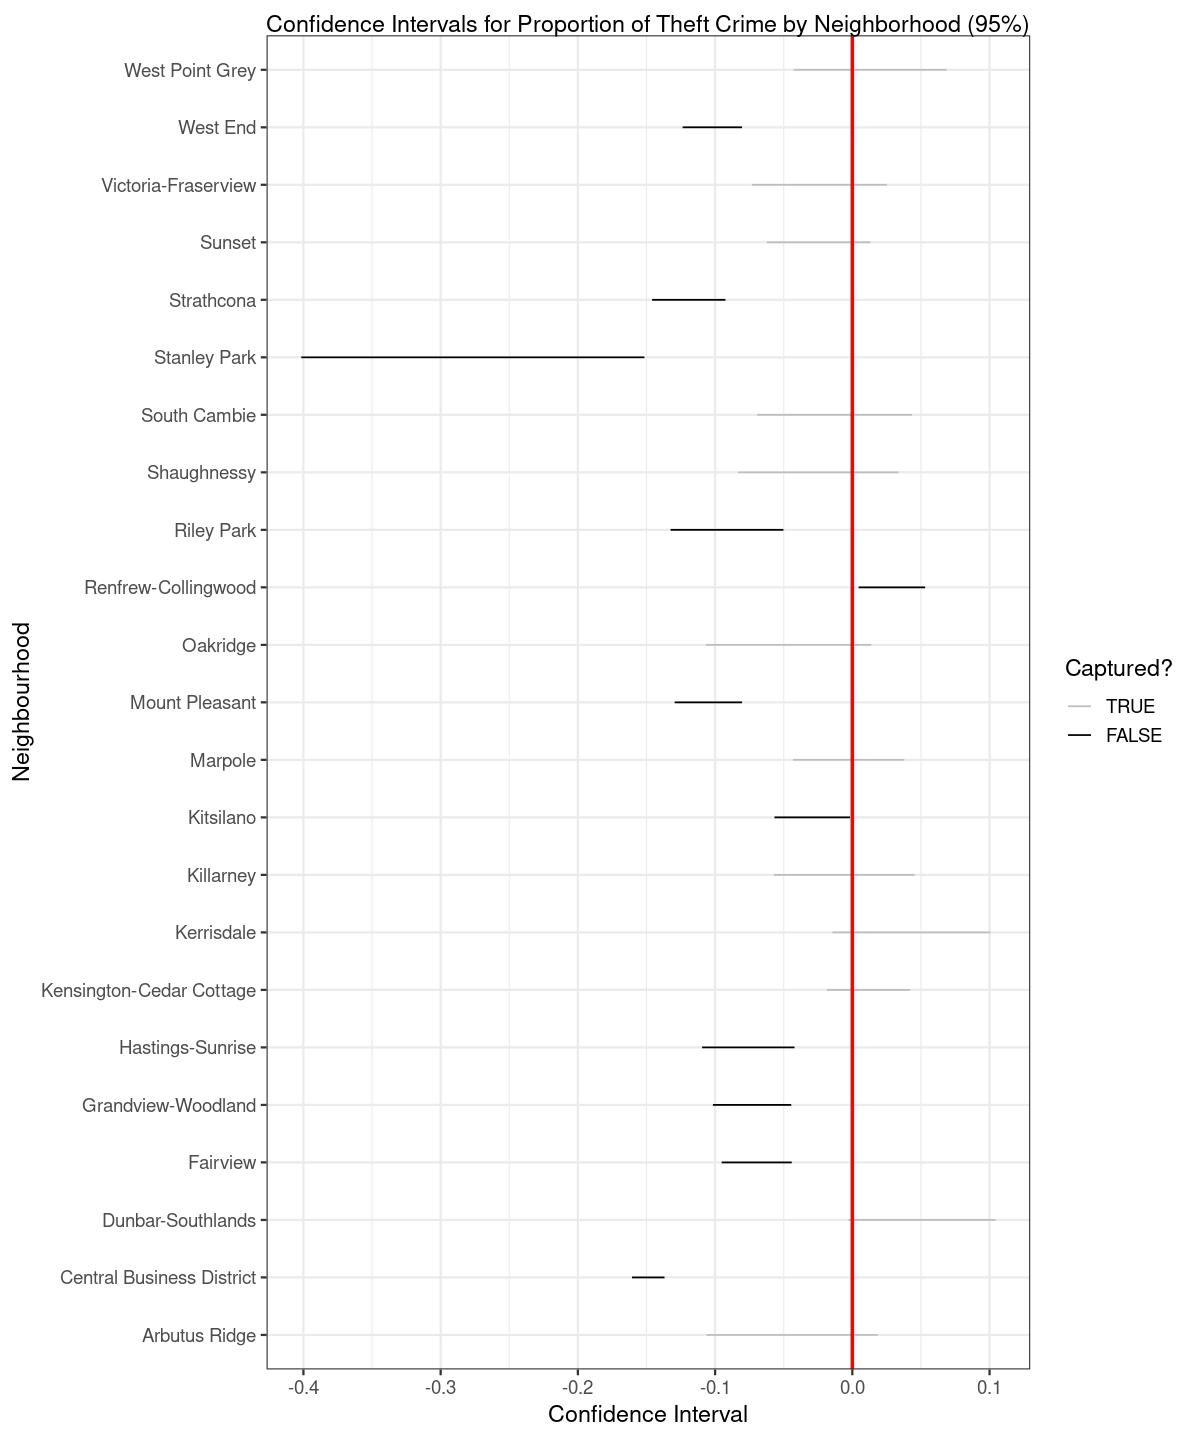

In [44]:
# Again, visualize if our confidence intervals captured zero
many_ci_plot_95 <- intervals_captured_95 %>%
    ggplot() +
    scale_colour_manual(breaks = c("TRUE", "FALSE"),
                        values = c("grey", "black")) +
    geom_segment(aes(x = lower_ci,
                     xend = upper_ci,
                     y = neighbourhood,
                     yend = neighbourhood,
                     colour = captured)) +
    geom_vline(xintercept = 0, colour = "red", size = 1) +
    labs(title = "Confidence Intervals for Proportion of Theft Crime by Neighborhood (95%)",
         y = "Neighbourhood",
         x = "Confidence Interval",
         colour = "Captured?") +
    theme_stat201(10, 12)

many_ci_plot_95
create_caption(33, "Visualizing confidence intervals generated via asymptotics")

Again, if the confidence interval captures zero, it means there's _no_ significant difference between crime rates of 2020 and before 2020. If the confidence interval doesn't capture 0, it means there is indeed a significant difference between crime rates of 2020 and before 2020. 

We find once again that based on 95% confidence interval with twenty four neighborhoods, twelve neighbourhoods capture zero and twelve do not.

### Bootstrapping or Asymptotics?

The argument of which method is preferred is relative clear within our analysis. While asymptotics is a completely valid technique, the variability in the the sample size of each neighborhood varied greatly, which meant the technique as a whole was limited; we even had to filter out the Musqueam neighborhood. In a case such as this one, there is truly nothing you can do to take a larger sample size. Using the CLT means our sample size must be "large enough," and when working with data such as this where there are many different sample sizes being studied at once, that can be a severe limitation.

Bootstrapping is a clear winner here. We could apply the technique on _all_ of the neighborhoods available in the data set without issue. This means that our preferable final results are as follows.

In [45]:
# Print our results again
neighbourhoods_bootstrap_result
create_caption(34, "A table showing our final P-values, found via bootstrapping.")

neighbourhood,past_prop,current_prop,diff_in_props,p_value,reject5
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
Fairview,0.6891537,0.6194740,-0.069679692,0.000,TRUE
West End,0.7351588,0.6331310,-0.102027854,0.000,TRUE
Central Business District,0.7533982,0.6046934,-0.148704859,0.000,TRUE
Hastings-Sunrise,0.6451613,0.5693642,-0.075797128,0.000,TRUE
Strathcona,0.5577118,0.4385246,-0.119187188,0.000,TRUE
Grandview-Woodland,0.6237392,0.5506849,-0.073054262,0.000,TRUE
Mount Pleasant,0.6768553,0.5719462,-0.104909124,0.000,TRUE
Sunset,0.5896720,0.5651163,-0.024555738,0.224,FALSE
Kensington-Cedar Cottage,0.6043016,0.6161616,0.011860044,0.440,FALSE


[1] "Figure #34: A table showing our final P-values, found via bootstrapping."


## Discussion

In our analysis, we found that after conducting a hypothesis test for each Vancouver neighborhood to see whether or not there was a statistically significant change in the proportion of theft related crime to all crime between 2020 and the average of 2017 to 2019 at a 5% significance level, roughly half of neighborhoods did not show a significant change. In tandem, we conducted an analysis using asymptotics, but ultimately found that bootstrapping would lead to more accurate results and would allow us to truly use available neighborhoods in our original data set.

Notably, looking at the neighborhoods where we do observe a difference, that difference is largely a _reduction_ in crime, as the difference in proportions was in fact negative. This would be a good candidate for further analysis, as we could use left-tailed tests, instead of two-tailed tests, to confirm whether this may indeed be a more general trend. This goes against what we anticipated to find; while COVID-19 has indeed led to an unprecedented economic decline for many countries and likewise many major cities across the world, it seems as though in Vancouver, this has not led to a distinct increase in theft-related crime across the board. Among the neighborhoods that we observed a statistically significant difference for, there is no clear economic grouping; there are so-called "middle class" neighborhoods like Fairview and West End, more "upper class" neighborhoods like Kitsilano, and "lower class" neighborhoods like Strathcona. At least in our analysis, there was no clear link between average income level in a neighborhood and whether or not a significant difference in the proportion of theft-related crime was observed.

There are many reason for why there might not be at difference in theft crime, and a decrease if there is a notable difference at all. "Petty" crimes such as theft often require some sort of human interaction; however, due to the pandemic, there has been an understandable reduction in amount of social interaction for anyone, including thieves. Additionally, locations where petty crimes may occur—such as restaurants, bars, or stores—have had to close their doors for sustained periods of time throughout 2020, and unfortunately into 2021, so there is clearly less opportunity for petty crimes to take place.

Additionally, it's worth returning to our initial point about "reported" crimes. Working with our data in this way, treating "reported" crimes as a sample of all "actual" crime, may simply be an inappropriate way to treat the data. Knowing just how many crimes go unreported is a daunting task to try to estimate, and while we were able to somewhat account for unreported crimes by applying inferential statistic techniques, the vast uncertainty and high sensitivity in these figures might render our results useless in the end. In 2020, it is likely that on whole, many thought longer before using the police in various situations; there has especially been a push, at least at the academia level, towards de-escalation (without involving the police) in small crimes such as the ones we look at in this report [[NYT Magazine, 15]](https://www.nytimes.com/interactive/2020/06/13/magazine/police-reform.html). Whether or not this has been observed in Vancouver is a question for future studies, but is again worth noting when interpreting our results.

## Reflection

In our final report, we expected to find that the rate of theft-related crime has changed significantly from past years, supporting the hypothesis that the pandemic is correlated to changing crime rates, including at local levels, with petty crimes. In fact, for roughly half of the neighborhoods in Vancouver, there has not been a statistically significant difference in the proportion of theft-related crime. While we did observe some noticeable differences in select neighborhoods, there was no evidence of any kind of systematic change in the year 2020 relative to previous years. Additionally, there was no correlation between economic status and neighborhoods that did observe as change.

Still, we anticipate the impact of our findings will be the production of actionable insights for both city officials and the VPD. Getting budgets right is hard, but using data-driven methods makes the process significantly easier. Through hypothesis testing, we can put both the safety and security of Vancouverites as a top priority, as weighing police funding versus additional social security measures is of utmost importance.

Three examples of further questions that could extend this analysis are:

1. Have other (perhaps, more small scale) pandemics affected the rate of theft-related crime? A study could be done of SARS in Toronto, from 2003-04.
2. How has COVID-19 affected the rate of theft-related crime at different cities across Canada? Cities could include: Calgary, Edmonton, Winnipeg, Regina, etc.
3. In what ways has the rate of violent crime changed since the pandemic began? We could look at the rate of more intense crimes, still on a city basis.

<hr >

## References

1. Statistics Canada, _The Social and Economic Impacts of COVID-19: A Six-Month Update_. Published October 20, 2020. [Source](https://www150.statcan.gc.ca/n1/pub/11-631-x/2020004/conclusions-eng.htm).

2. Interpol, _Operation Pangea – shining a light on pharmaceutical crime_. Published November 21, 2019. [Source](https://www.interpol.int/en/News-and-Events/News/2019/Operation-Pangea-shining-a-light-on-pharmaceutical-crime).

3. ABC News, _FBI warns of potential surge in hate crimes against Asian Americans amid coronavirus_. Published March 27, 2020. [Source](https://abcnews.go.com/US/fbi-warns-potential-surge-hate-crimes-asian-americans/story?id=69831920).

4. UN News, _UN chief calls for domestic violence ‘ceasefire’ amid ‘horrifying global surge’_. Published April 6, 2020. [Source](https://news.un.org/en/story/2020/04/1061052).

5. CBC, _City of Vancouver freezes police department funding as part of 2021 budget_. Published December 8, 2020. [Source](https://www.cbc.ca/news/canada/british-columbia/city-of-vancouver-freezes-police-department-funding-as-part-of-2021-budget-1.5833731).

6. Vancouver Police Department, _Crime Data_. Accessed March 5, 2021. [Source](https://geodash.vpd.ca/opendata/).

7. Piazza, _Group Project clarification_. Published March 4, 2021. [Source](https://piazza.com/class/kjqe81ynudx2rm?cid=169).*

8. Wright, Bradley R. Entner, Avshalom Caspi et al in Criminology, _RECONSIDERING THE RELATIONSHIP BETWEEN SES AND DELINQUENCY: CAUSATION BUT NOT CORRELATION_. Published March 7, 2006. [Source](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1745-9125.1999.tb00483.x).

9. City of Vancouver, _Census local area profiles 2016_. Published April 10, 2018. [Source](https://opendata.vancouver.ca/explore/dataset/census-local-area-profiles-2016/information/).

10. New York Times, _Confidence in Police Is at Record Low, Gallup Survey Finds_. Published August 12, 2020. [Source](https://www.nytimes.com/2020/08/12/us/gallup-poll-police.html).

11. Wickham, Hadley and Garrett Grolemund, _R for Data Science_. Published December 2016. [Source](https://r4ds.had.co.nz/).

12. Timbers, Tiffany-Anne, Trevor Campbell and Melissa Lee, _Data Science: A First Introduction_. Last updated January 12, 2021. [Source](https://ubc-dsci.github.io/introduction-to-datascience/).

13. Statistics Canada, _Police-reported crime statistics in Canada, 2019_. Published October 29, 2020. [Source](https://www150.statcan.gc.ca/n1/pub/85-002-x/2020001/article/00010-eng.htm).

14. Statistics Canada, _Public perceptions of the police in Canada’s provinces, 2019_. Published November 25, 2020. [Source](https://www150.statcan.gc.ca/n1/pub/85-002-x/2020001/article/00014-eng.htm).

15. Bazelon, Emily, _New York Times Magazine._ Published June 13, 2020. [Source](https://www.nytimes.com/interactive/2020/06/13/magazine/police-reform.html).

\* Note the Piazza reference is used to ensure we're handling a proportions analysis correctly, since it was a bit unclear in the instructions.

In [46]:
# Delete unzipped files, and the zip archive
unlink("*.csv")
unlink("*.txt")
unlink("*.pdf")
unlink("*.zip")

<a id='appendix'><h2>Appendix</h2></a>


In our analysis, we often reference the socioeconomic status of various neighborhoods in Vancouver. The following code cells display the full economic distribution we reference, from the 2016 City of Vancouver Census, available [here](https://opendata.vancouver.ca/explore/dataset/census-local-area-profiles-2016/information/).

First, we'll need to tidy the data. To do so, we'll clean up the column names using `clean_names()`, grab the survey question we're interested in from the data set, and use `gather(...)` to switch the neighborhoods from being column names to an actual column value, `neighbourhood`, themselves. 

In [47]:
# Read in data from the City of Vancouver "opendata" website
url <- "https://webtransfer.vancouver.ca/opendata/csv/CensusLocalAreaProfiles2016.csv"
census <- read_csv(url, skip = 4) %>%
    clean_names()

head(census)
create_caption(35, "Exploring Vancouver census data")


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_number(),
  ID = col_double(),
  Variable = col_character()
)
i Use `spec()` for the full column specifications.


Warning message:
"1 parsing failure.
 row col               expected         actual                                                                            file
1879  ID no trailing characters 25% Data Below 'https://webtransfer.vancouver.ca/opendata/csv/CensusLocalAreaProfiles2016.csv'
"


id,variable,arbutus_ridge,downtown,dunbar_southlands,fairview,grandview_woodland,hastings_sunrise,kensington_cedar_cottage,kerrisdale,⋯,riley_park,shaughnessy,south_cambie,strathcona,sunset,victoria_fraserview,west_end,west_point_grey,vancouver_csd,vancouver_cma
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Total - Age groups and average age of the population - 100% data,15295,62030,21425,33620,29175,34575,49325,13975,⋯,22555,8430,7970,12585,36500,31065,47200,13065,631485,2463430
2,0 to 14 years,2015,4000,3545,2580,3210,4595,7060,1880,⋯,3415,1175,1105,1065,5460,3790,1945,1900,70530,362110
3,0 to 4 years,455,2080,675,1240,1320,1510,2515,430,⋯,1175,270,360,360,1695,1175,965,420,24615,116270
4,5 to 9 years,685,1105,1225,760,1025,1560,2390,600,⋯,1160,405,365,365,1780,1210,560,670,22905,122730
5,10 to 14 years,880,810,1650,580,865,1525,2160,845,⋯,1080,500,375,340,1985,1410,415,810,23010,123110
6,15 to 64 years,9805,51275,14215,25140,22535,23945,35385,9395,⋯,15875,5440,5430,8745,25490,21090,38255,8660,463390,1714005


[1] "Figure #35: Exploring Vancouver census data"


In [48]:
# This the the question in the `variable` column we care about
INCOME_QUESTION <- "Average total income in 2015 among recipients ($)"

# Grab all neighborhoods' average incomes
neighbourhood_income <- census %>%
    filter(variable == INCOME_QUESTION) %>%
    head(1) %>% # we're only interested in the first row; the subsequent rows with this `variable` contain data for only a segment of the population (e.g., males)
    gather(neighborhood, income, arbutus_ridge:vancouver_cma) %>% # convert "wide" data to long with `gather`
    select(-variable, -id) # drop columns we're not interested in 

head(neighbourhood_income)
create_caption(36, "Explored tidied census data")

neighborhood,income
<chr>,<dbl>
arbutus_ridge,62675
downtown,63251
dunbar_southlands,78117
fairview,61627
grandview_woodland,42896
hastings_sunrise,38258


[1] "Figure #36: Explored tidied census data"


In [49]:
# We can gather some summary statistics as well
neighbourhood_income_summary <- neighbourhood_income %>%
    summarize(max = max(income),
              min = min(income),
              mean = mean(income),
              median = median(income))

neighbourhood_income_summary
create_caption(37, "A table containing summary statistics for Vancouver census data")

max,min,mean,median
<dbl>,<dbl>,<dbl>,<dbl>
118668,31534,54225.29,48785


[1] "Figure #37: A table containing summary statistics for Vancouver census data"


Now that we've tidied the data, we can visualize it in a histogram, to see the overall distribution, and a bar chart, to view the income by neighborhood.

[1] "Figure #38: A histogram of wealth across Vancouver neighborhoods"


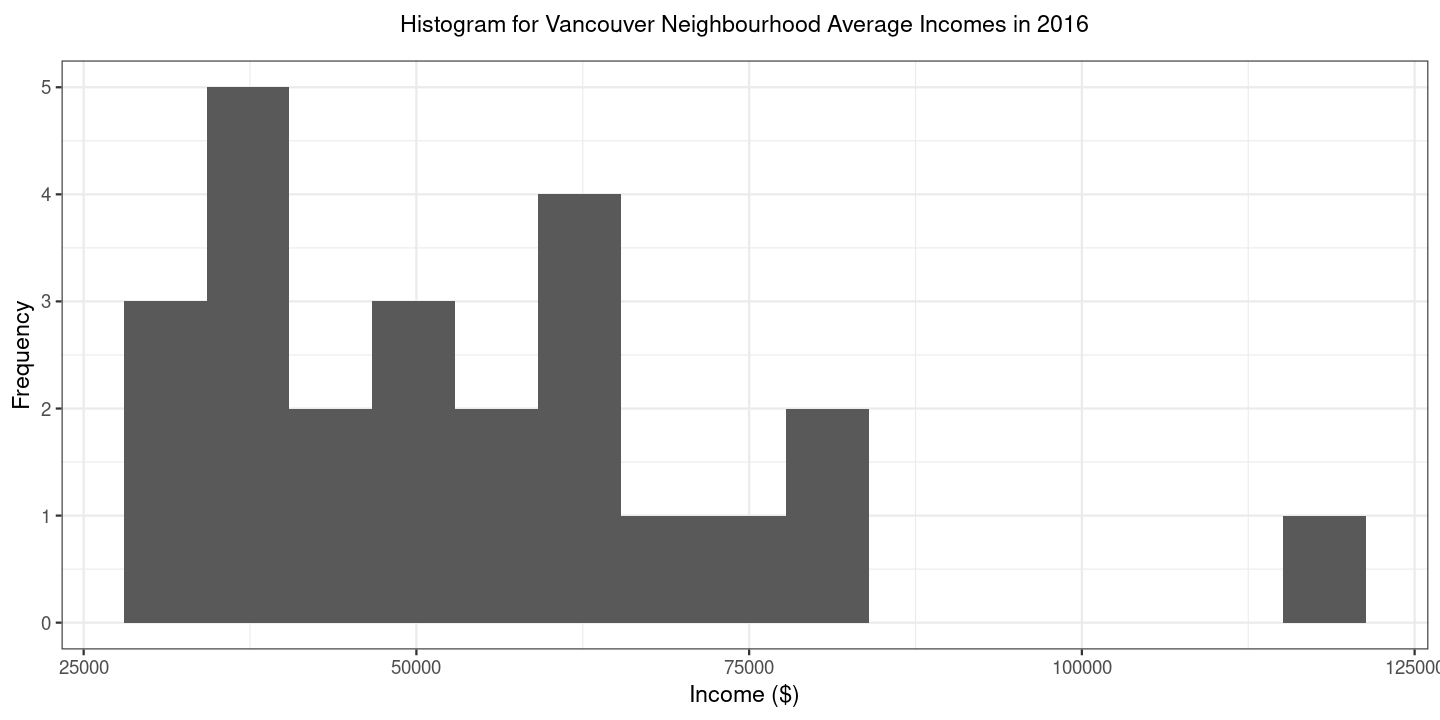

In [50]:
# Visualize income data on a histogram
neighbourhood_income_histogram <- neighbourhood_income %>%
    ggplot(aes(x = income)) +
    geom_histogram(bins = 15) +
    labs(
        title = "Histogram for Vancouver Neighbourhood Average Incomes in 2016\n",
        x = "Income ($)",
        y = "Frequency"
    ) +
    theme_stat201(12, 6)

neighbourhood_income_histogram
create_caption(38, "A histogram of wealth across Vancouver neighborhoods")

The distribution is mostly centers around the $50,000 mark, though it has no clear peak. The histogram makes clear there is one notable outlier from the data.

[1] "Figure #39: A bar plot of wealth across Vancouver neighborhoods"


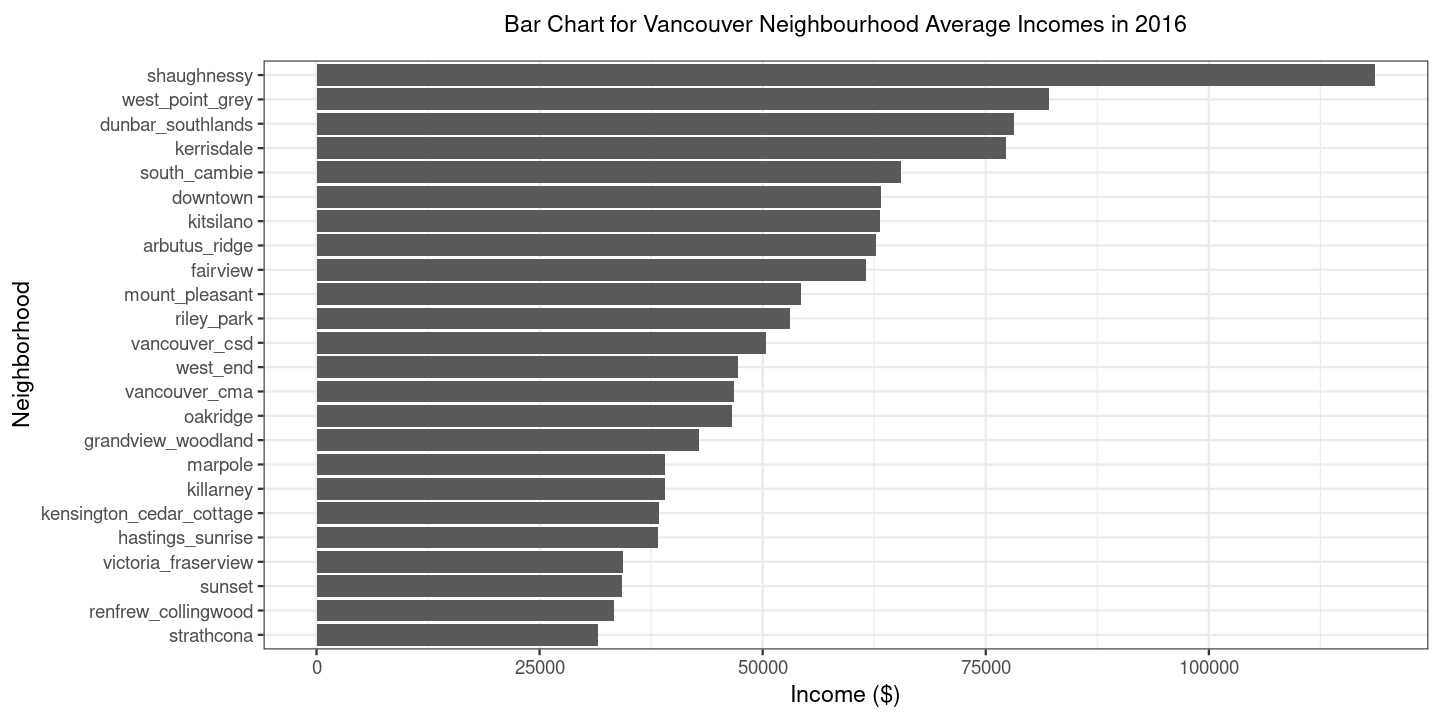

In [51]:
# Visualize income data on a barplot
neighbourhood_income_barplot <- neighbourhood_income %>%
    ggplot(aes(x = reorder(neighborhood, income), y = income)) +
    geom_bar(stat = "identity") +
    labs(
        title = "Bar Chart for Vancouver Neighbourhood Average Incomes in 2016\n",
        x = "Neighborhood",
        y = "Income ($)"
    ) +
    coord_flip() +
    theme_stat201(12, 6)
neighbourhood_income_barplot
create_caption(39, "A bar plot of wealth across Vancouver neighborhoods")

The bar chart, as a follow-up, shows that it is indeed the Shaughnessy neighborhood that is a clear outlier in terms of average income of residents in 2016. The bar chart shows there are some natural groups that can be made, such as Strathcona to Victoria/Fraserview as "very low", Hastings/Sunrise to Marpole as "low", etc., that do not necessarily fit into a prescribed dichotomy like "lower class," "middle class," and "upper class."

Both the histogram and the bar plot will be reference throughout the analysis to aid the interpretation of the results.